In [1]:
%pylab inline
import seaborn as sns; sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19, 14
sns.set_context('poster', font_scale=1.4)
import pandas as pd
from scipy.stats import iqr
from warnings import filterwarnings
filterwarnings('ignore')
import pickle

Populating the interactive namespace from numpy and matplotlib


## Load in datasets

P.S. The following cell will consume around 28 GBs of memory

In [2]:
df1 = pd.read_parquet('/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/COSMODC2v1.1.4/10_year_error_estimates/OLIVIA_WORK/final-result.parquet')
df2 = pd.read_parquet('/global/cfs/cdirs/lsst/groups/PZ/PhotoZDC2/COSMODC2v1.1.4/FZBOOST_SAMPLE/FlexZBoost_random_sample_0_1.parquet')
df3 = pd.read_parquet('/global/cfs/cdirs/lsst/groups/PZ/PhotoZDC2/COSMODC2v1.1.4/FZBOOST_SAMPLE/FlexZBoost_random_sample_1_2.parquet')
df4 = pd.read_parquet('/global/cfs/cdirs/lsst/groups/PZ/PhotoZDC2/COSMODC2v1.1.4/FZBOOST_SAMPLE/FlexZBoost_random_sample_2_3.parquet')
df2 = pd.concat((df2, df3, df4)).reset_index()
bpz = pd.read_hdf('/global/cscratch1/sd/husni/subsample_bpz.hdf5', key='Bin_8')
for b in ['Bin_'+str(i) for i in range(1,9)]:
    bpz = pd.concat((bpz, pd.read_hdf('/global/cscratch1/sd/husni/subsample_bpz.hdf5', key=b))).reset_index()

## Visualize Datasets

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4759: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':


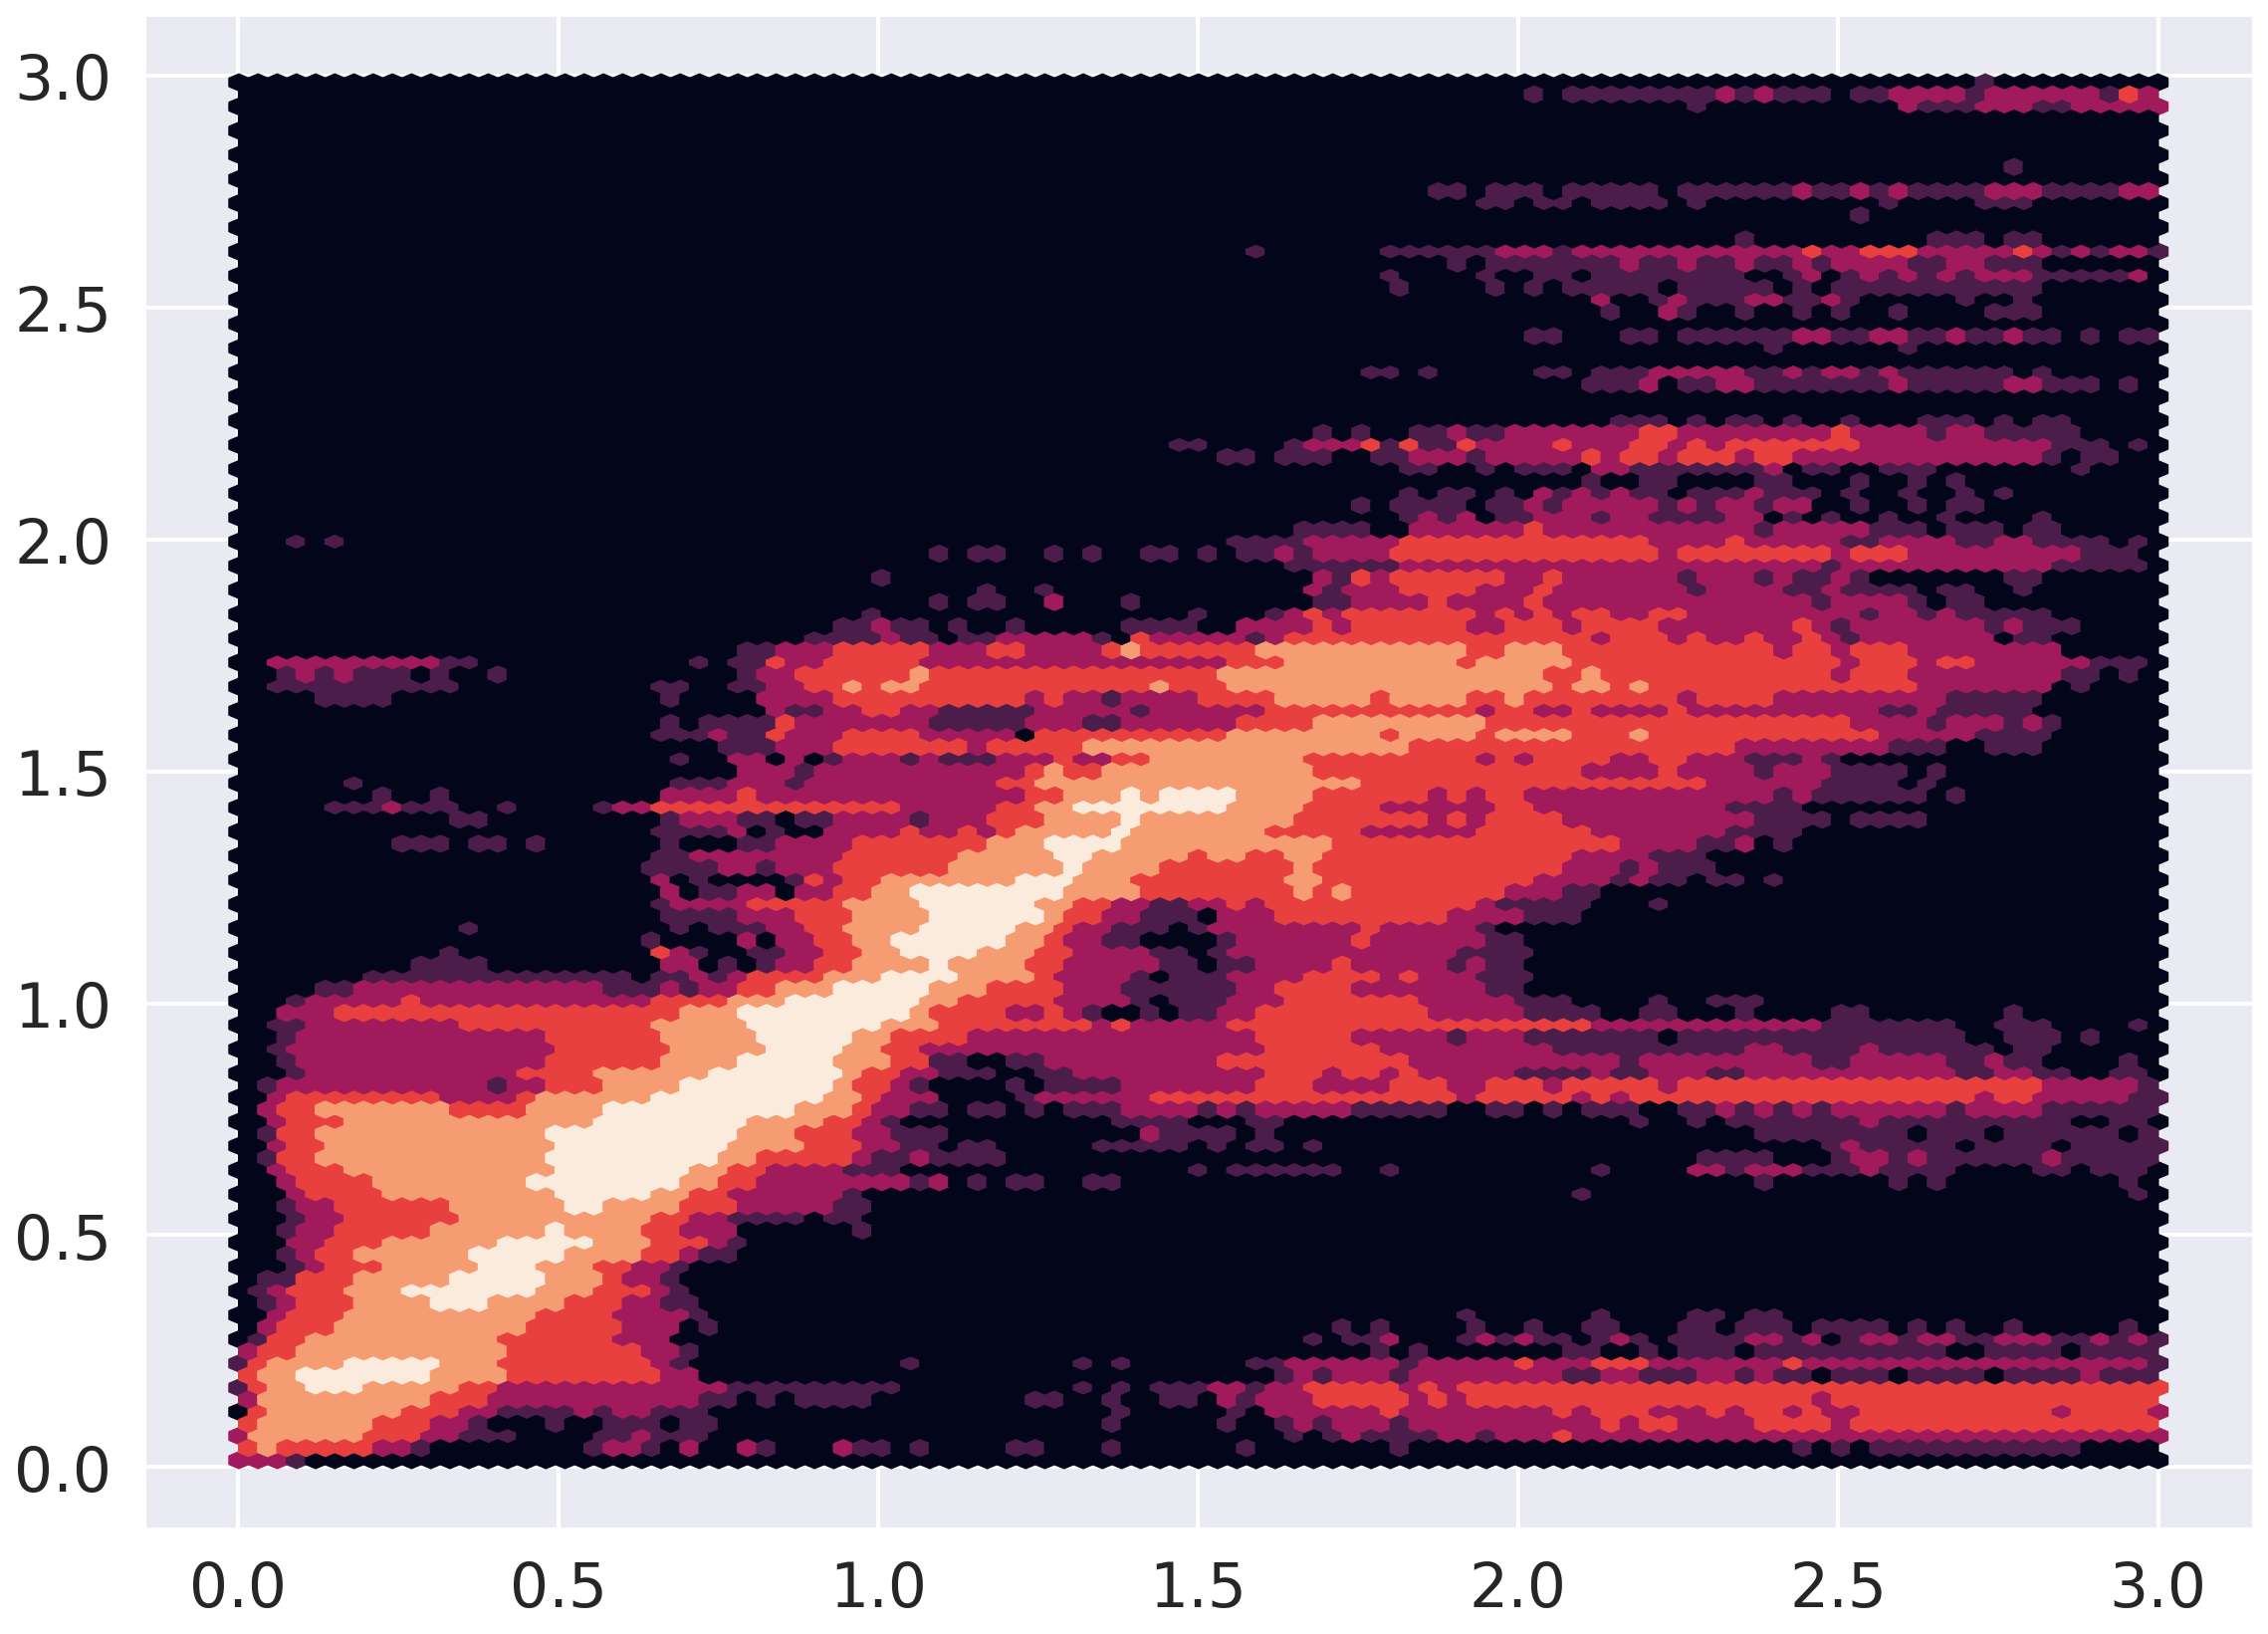

In [11]:
plt.hexbin(df['rz_real'], df['photoz_mode'], bins=np.logspace(0, 4, 5))

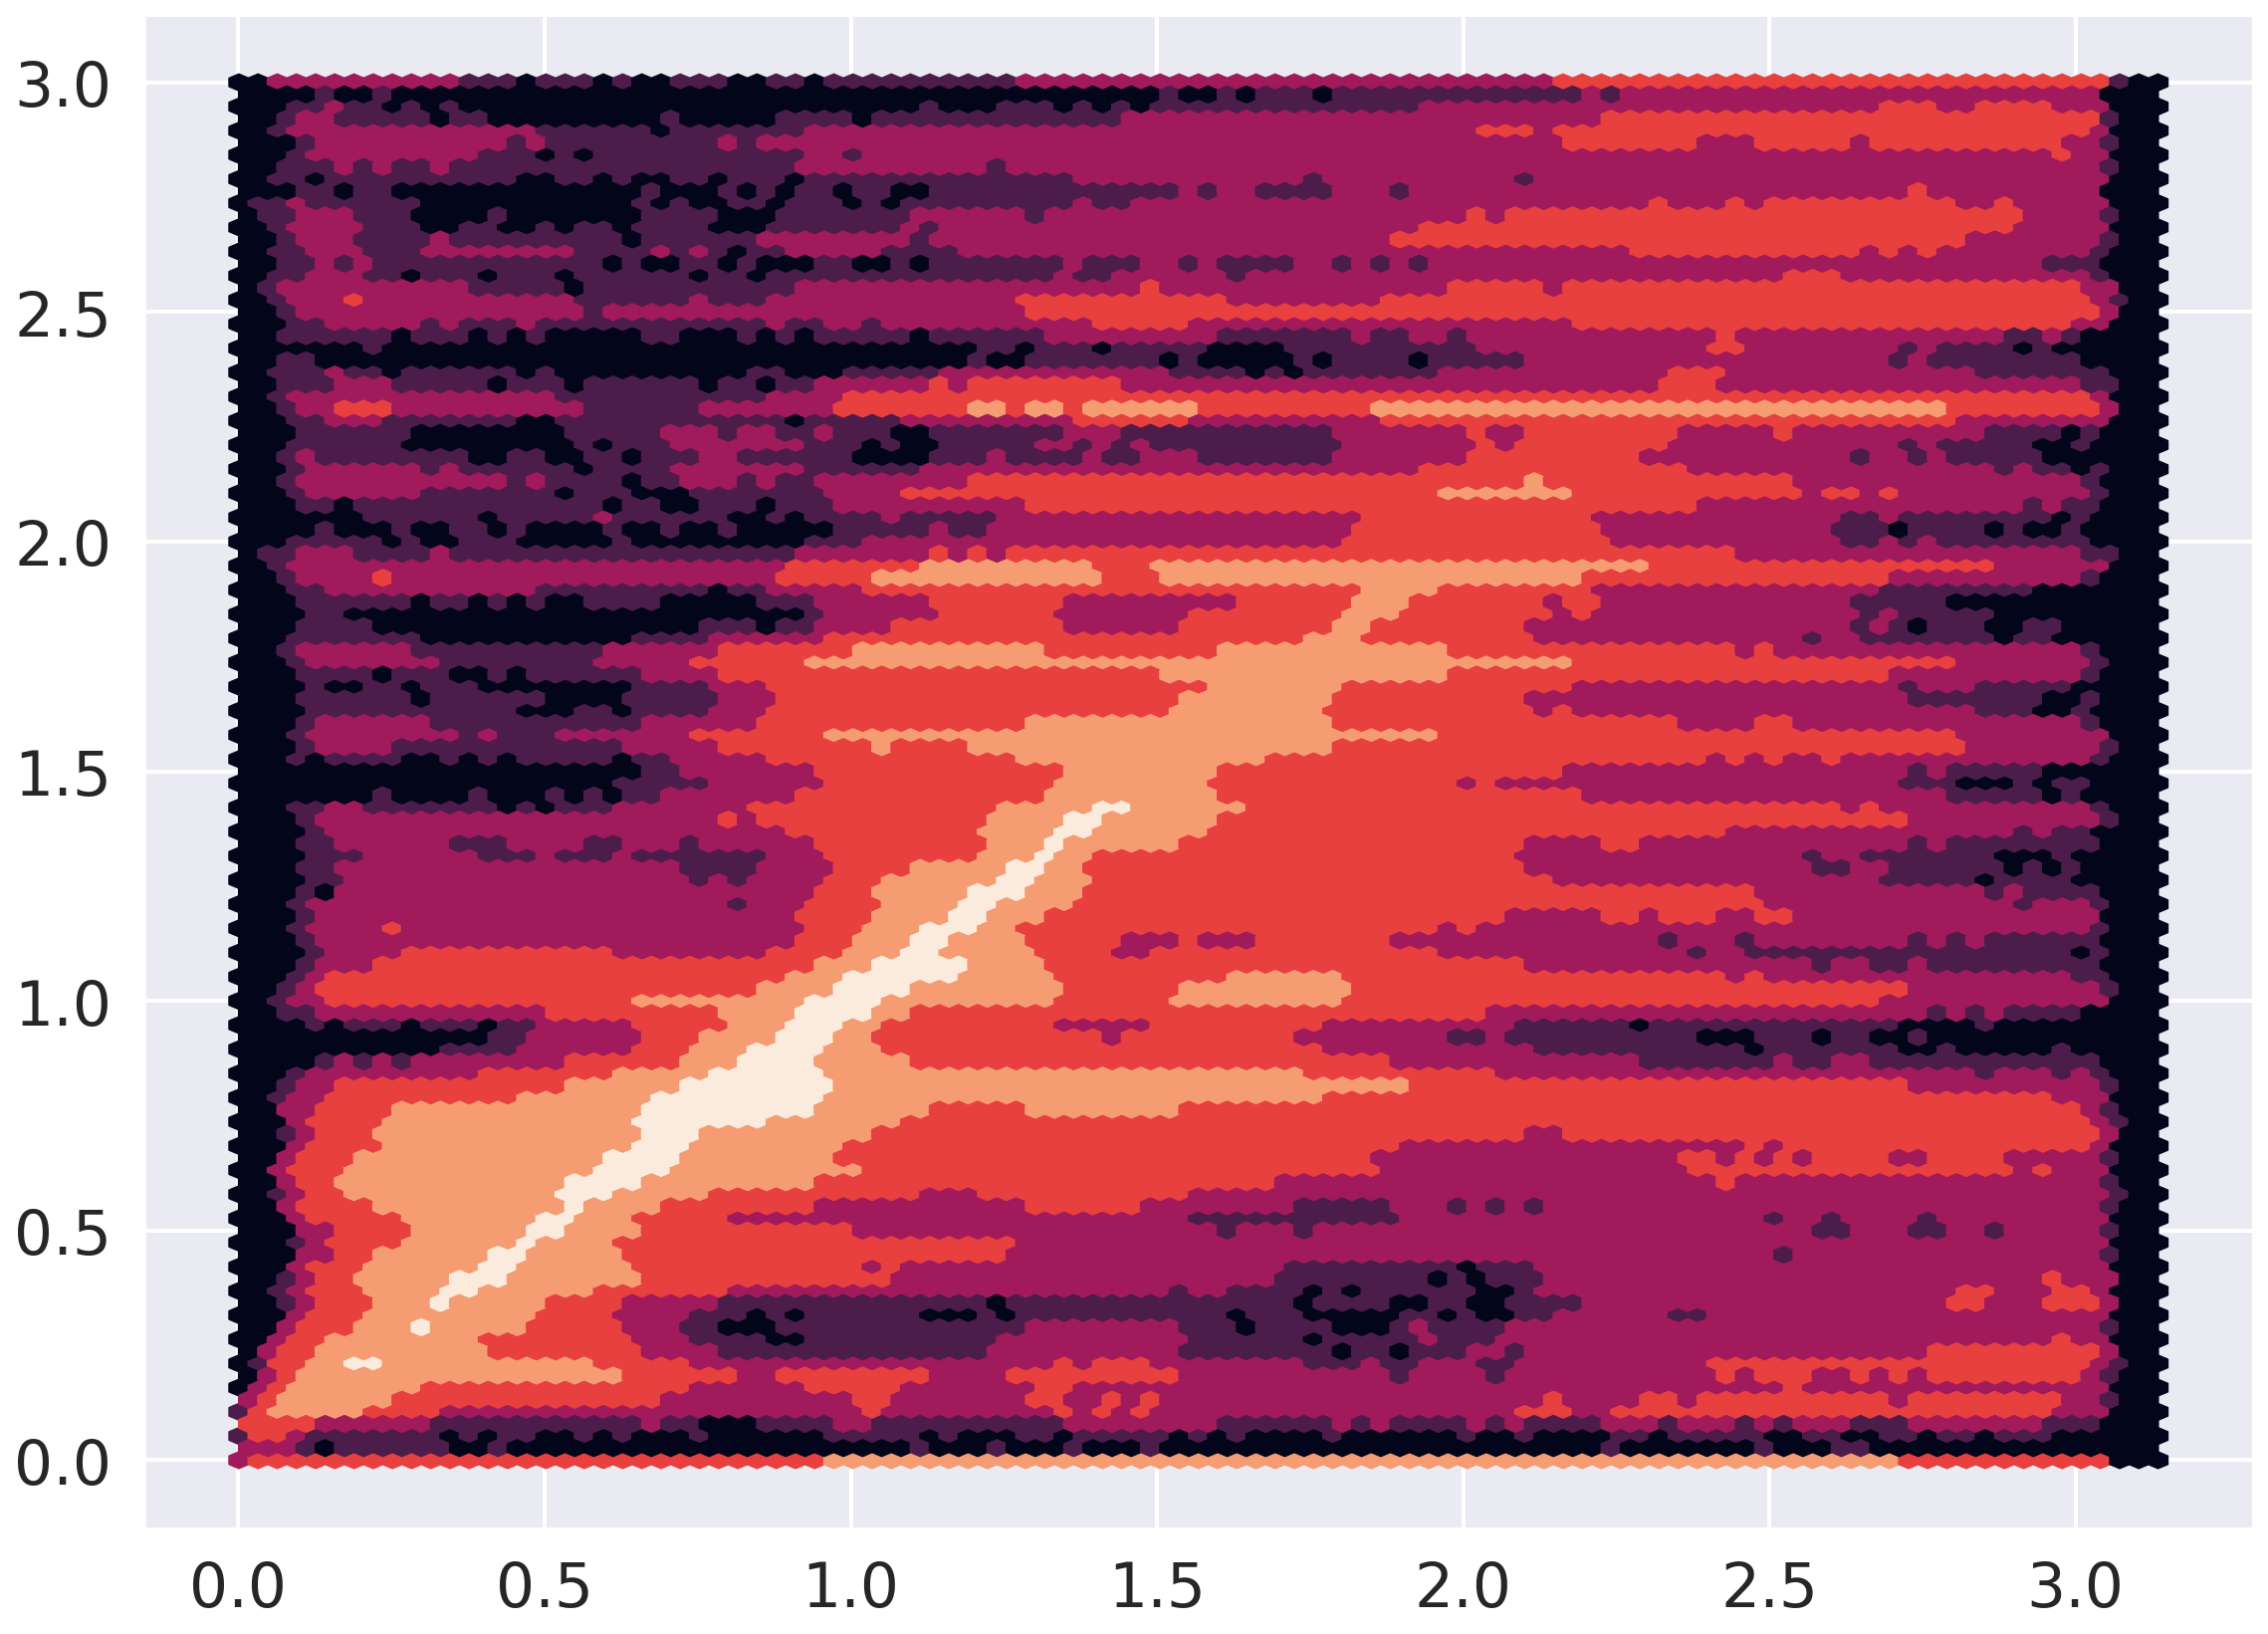

In [26]:
plt.hexbin(df2['redshift'], df2['photoz_mode'], bins=np.logspace(0, 4, 5))

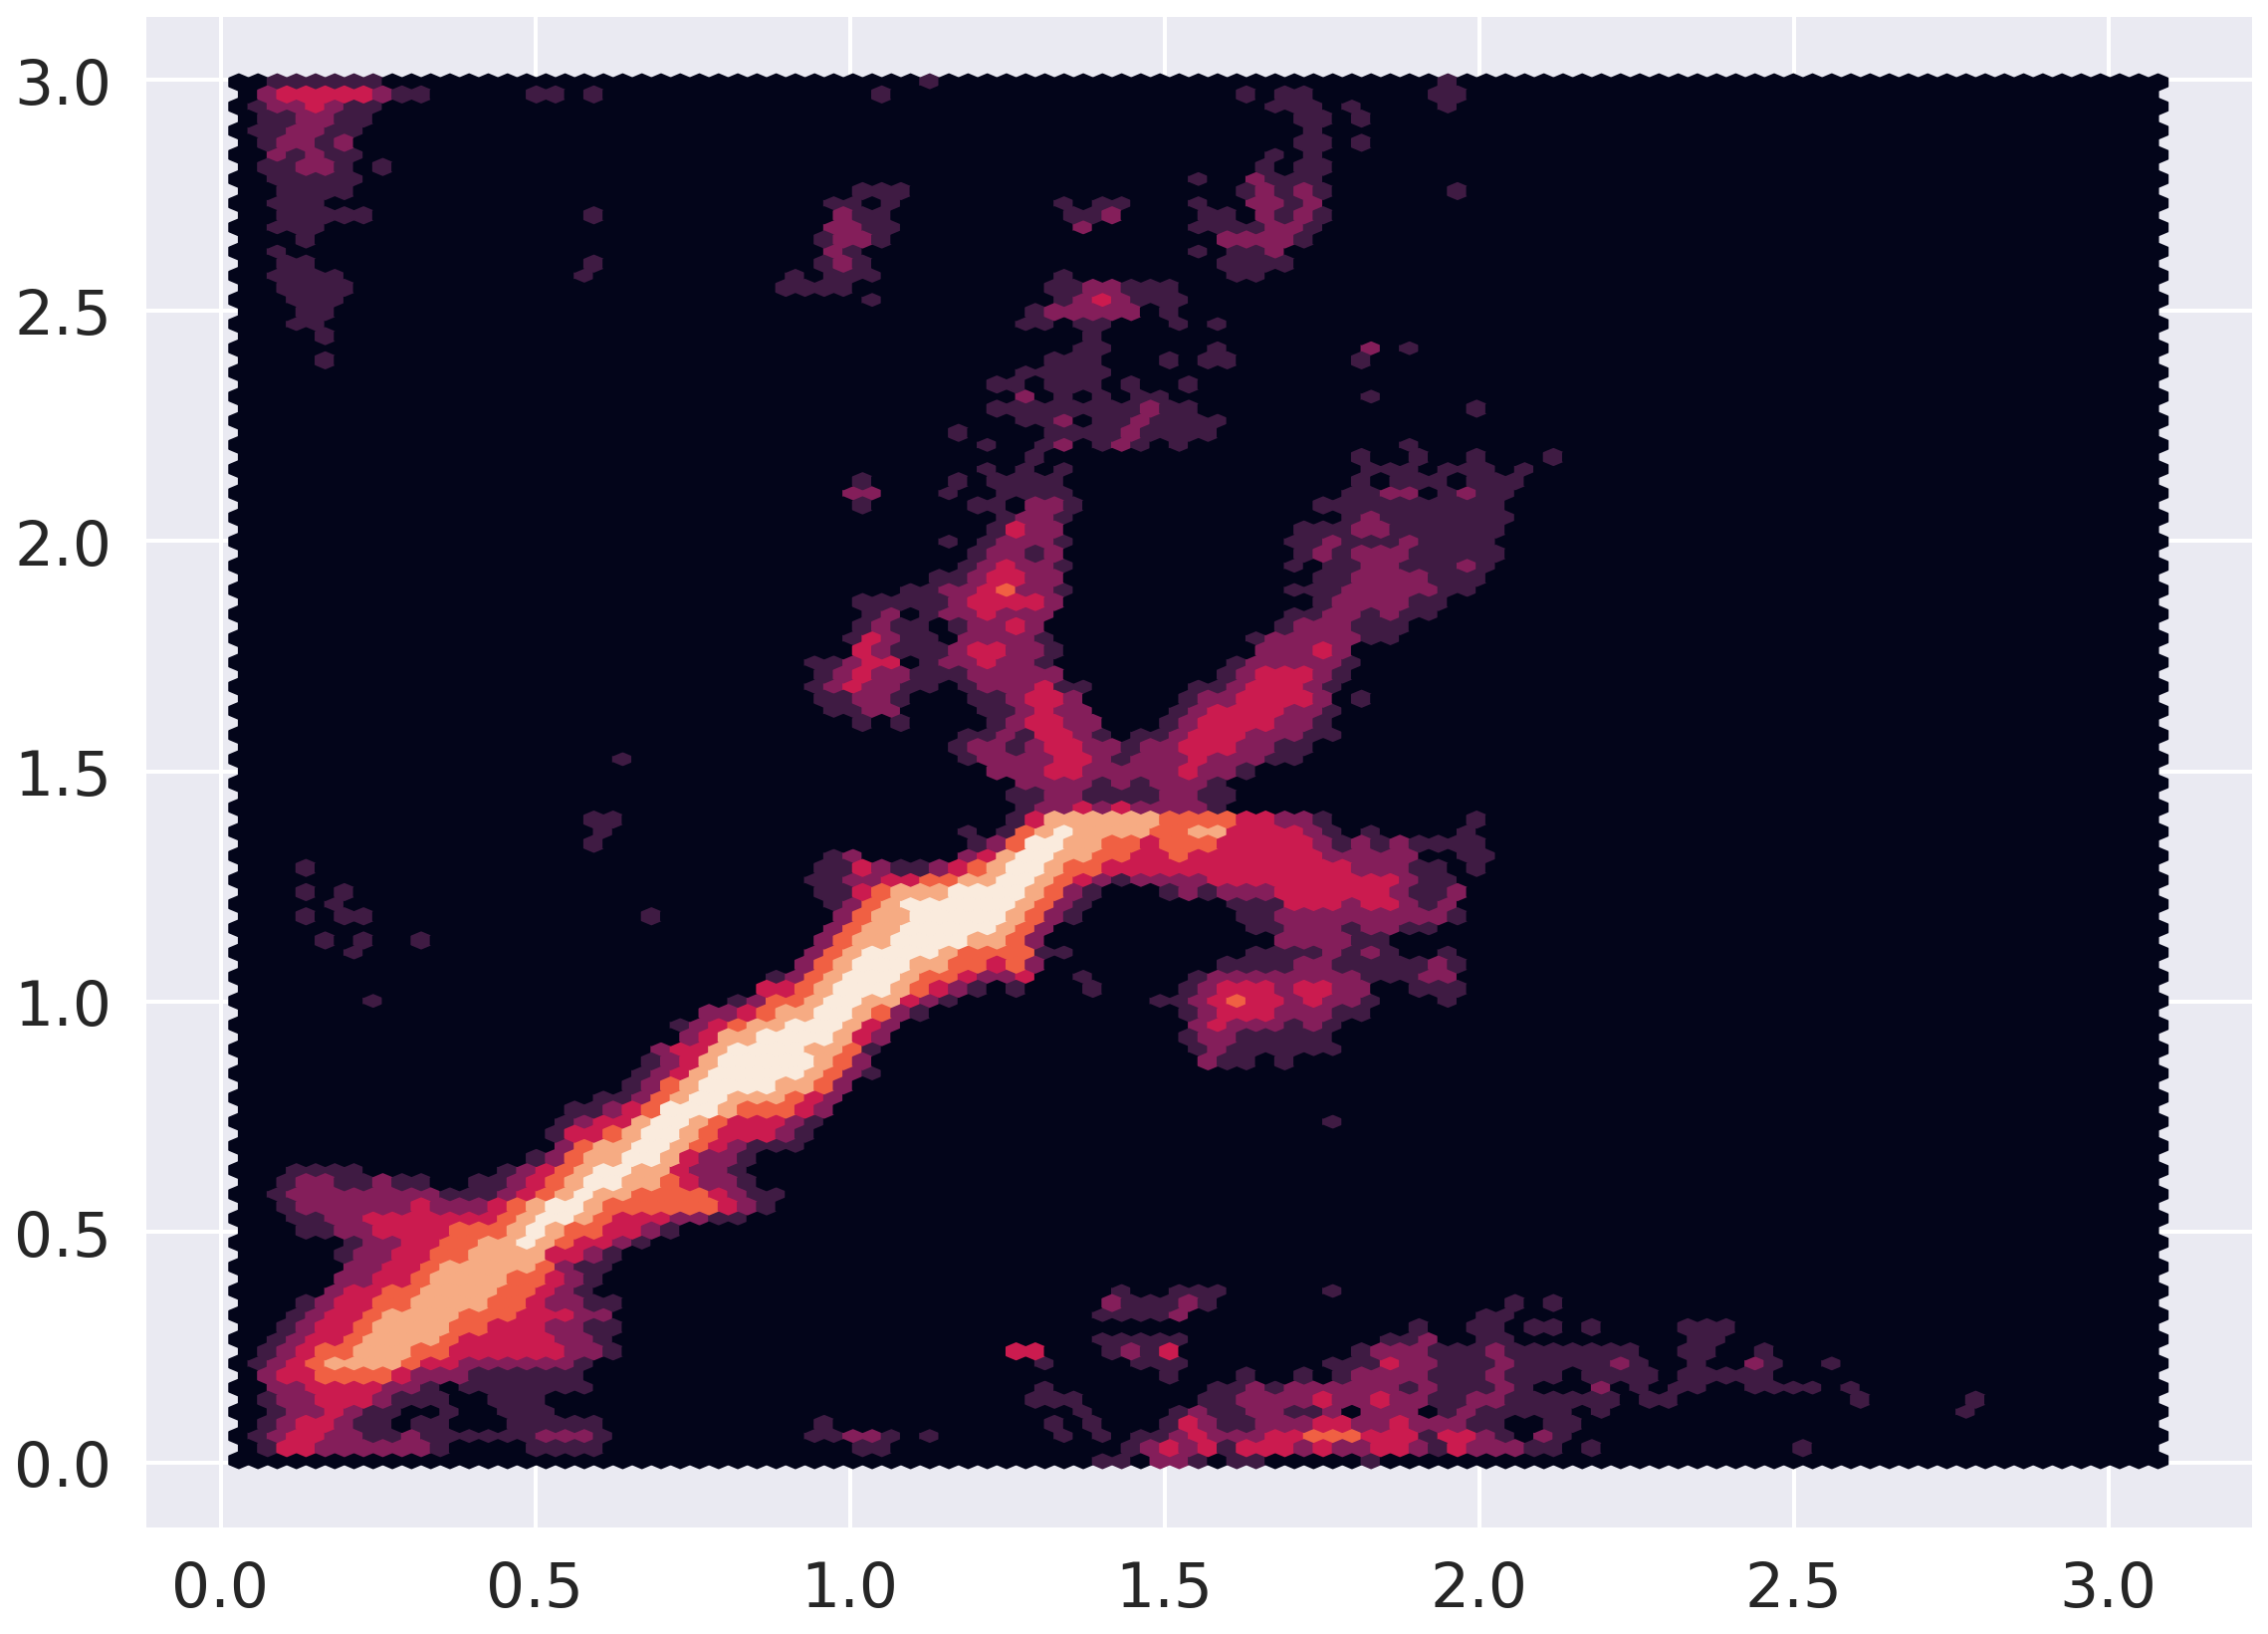

In [22]:
plt.hexbin(bpz['redshift_lsst'], bpz['galaxy_points_z_mode'], bins=np.logspace(1,5,10))

# Error Statistics
## Robust Bias (with outliers taken out first)

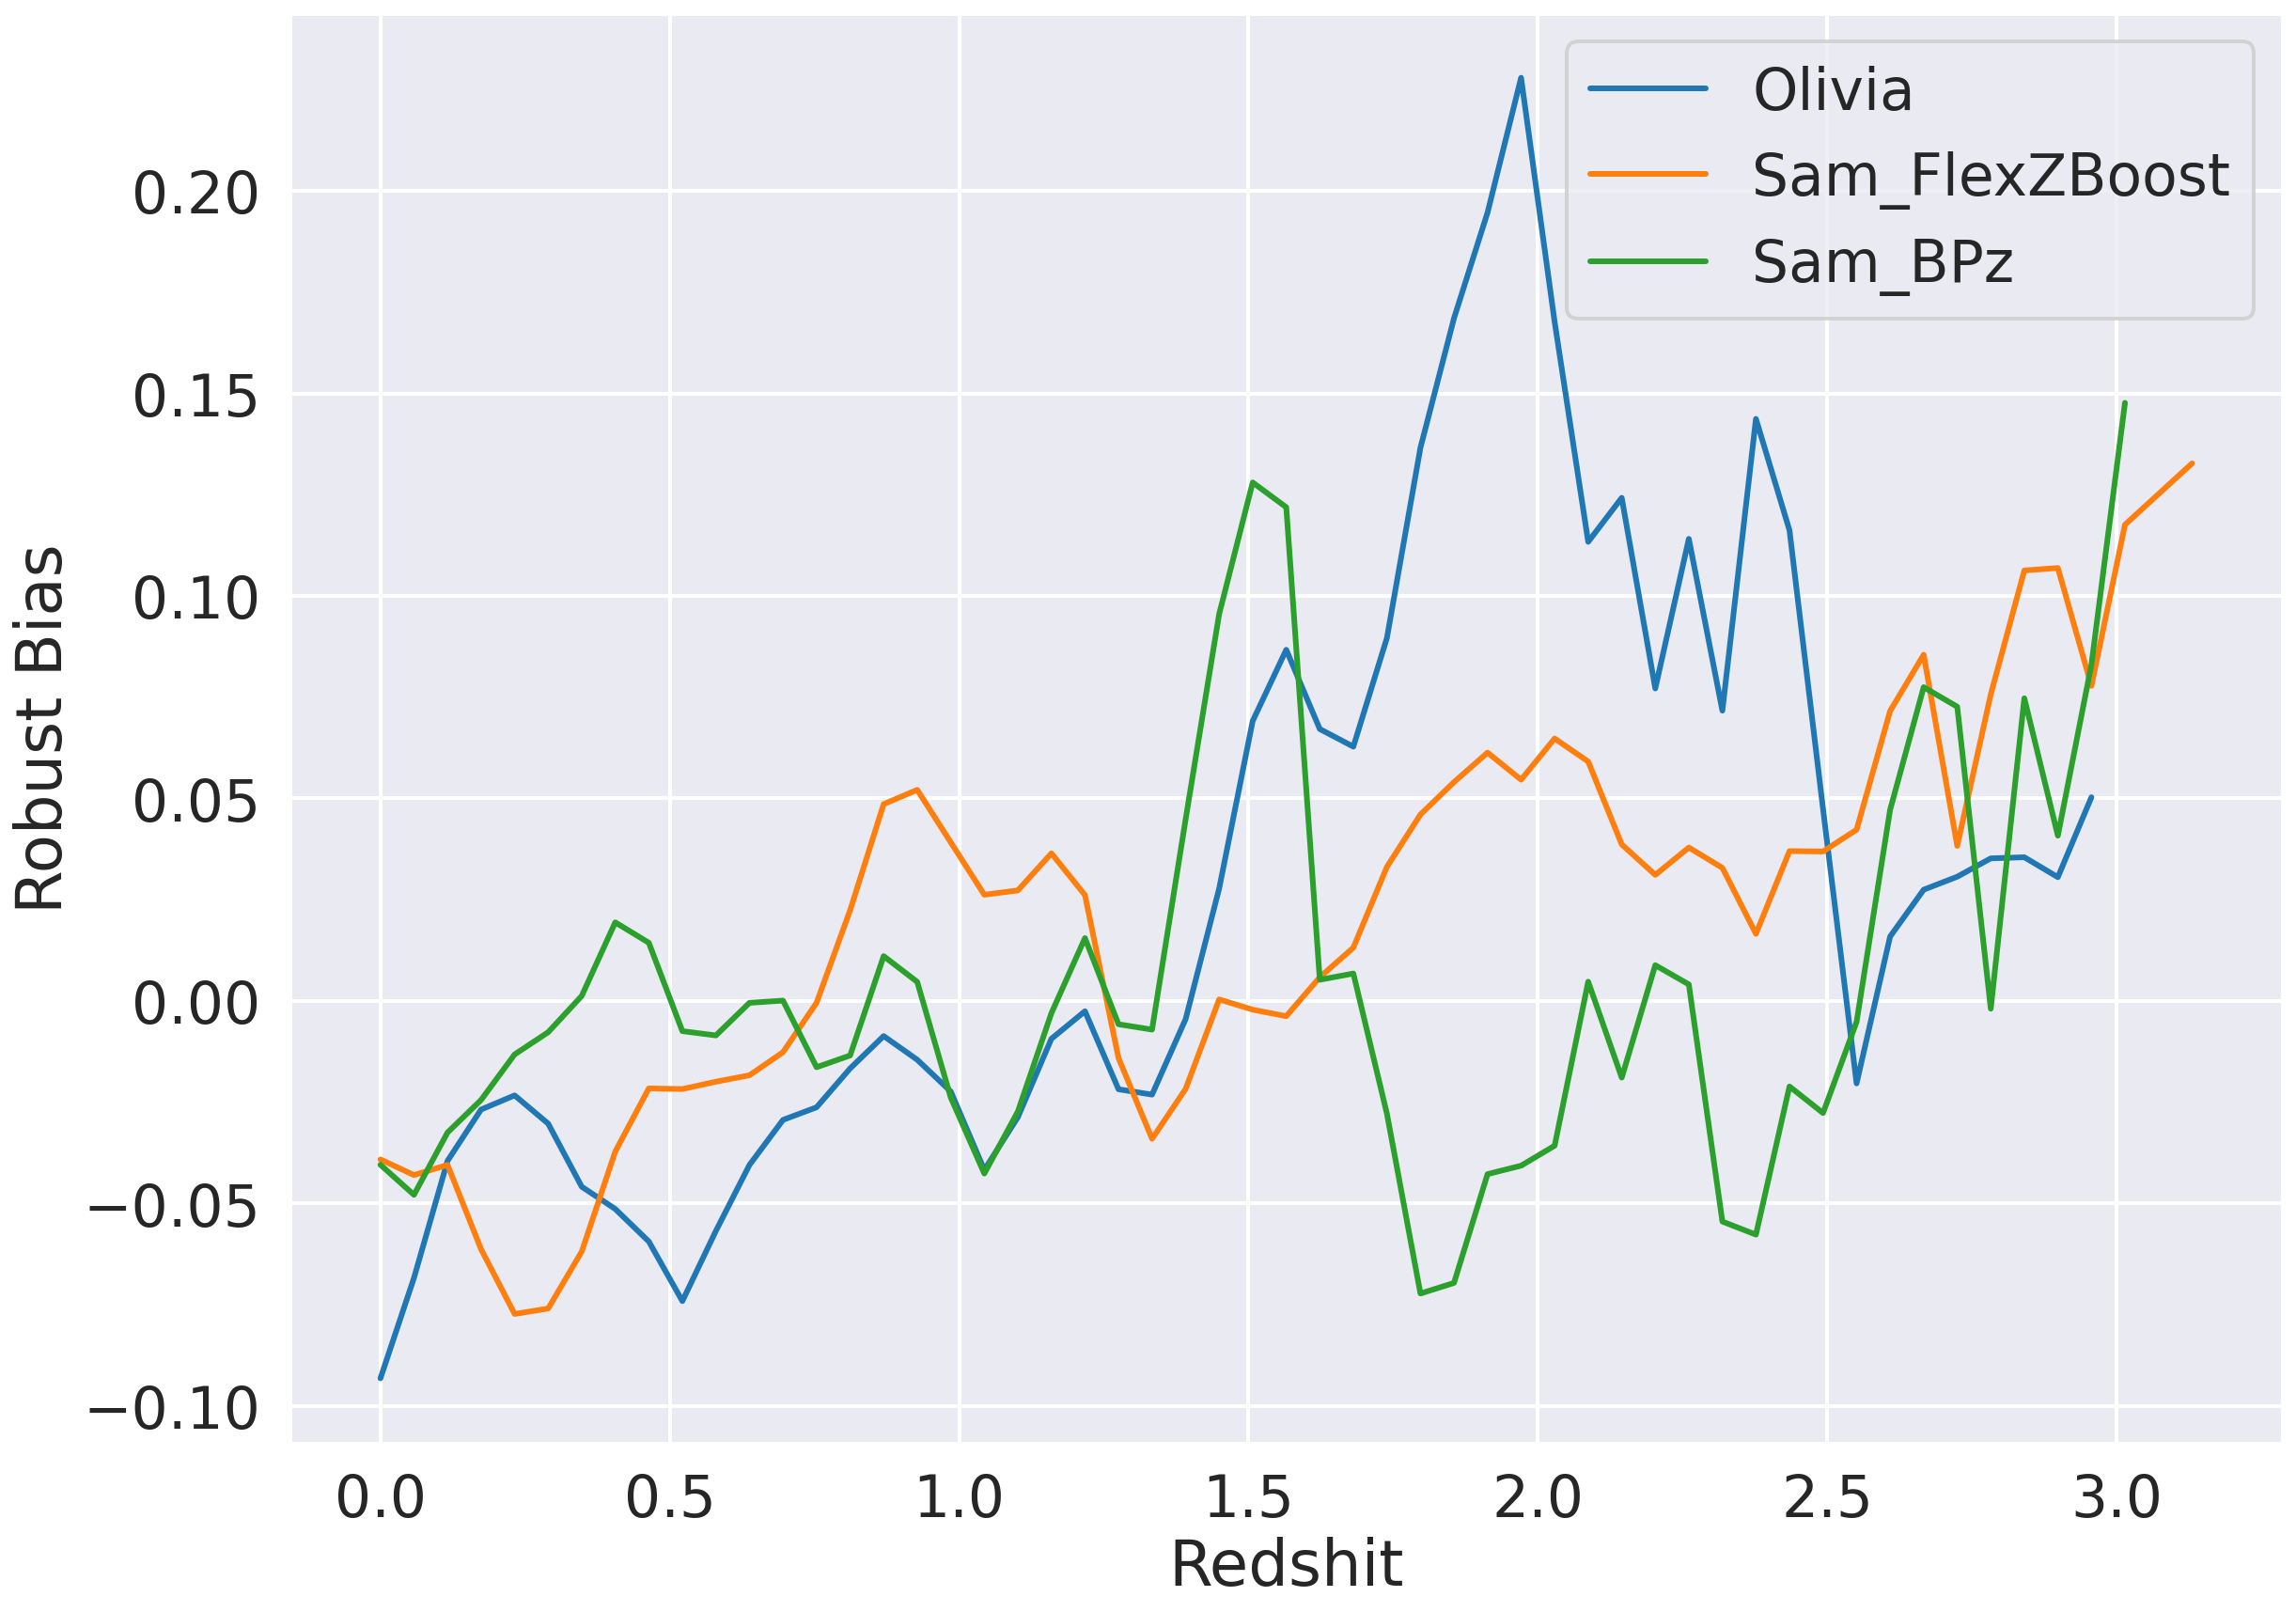

In [54]:

save = {}
edges = np.linspace(0, 4, 70)
for data in zip([df1, df2, bpz],
                ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                ['rz_real', 'redshift', 'redshift_lsst'],
                ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
    binned_data = []
    for i in range(len(edges)-1):
        df = data[0]
        data_in_bin = df[np.logical_and(df[data[2]]>edges[i], df[data[2]]<edges[i+1])] 
        outliers = np.abs(data_in_bin[data[2]] - data_in_bin[data[3]]) > 3 * iqr(df[data[2]] - df[data[3]])
        binned_data.append(data_in_bin[~outliers])
    x = edges[:-1]
    y = [np.mean(d[data[2]])-np.mean(d[data[3]]) for d in binned_data]
    sns.lineplot(x, y, label=data[1], markers=True)
    save[data[1]] = {'redshift':x, 'bias':y}
plt.legend()
plt.ylabel('Robust Bias')
plt.xlabel('Redshit')

pickle.dump(save, open('robust_bias.p', 'wb'))

## Bias

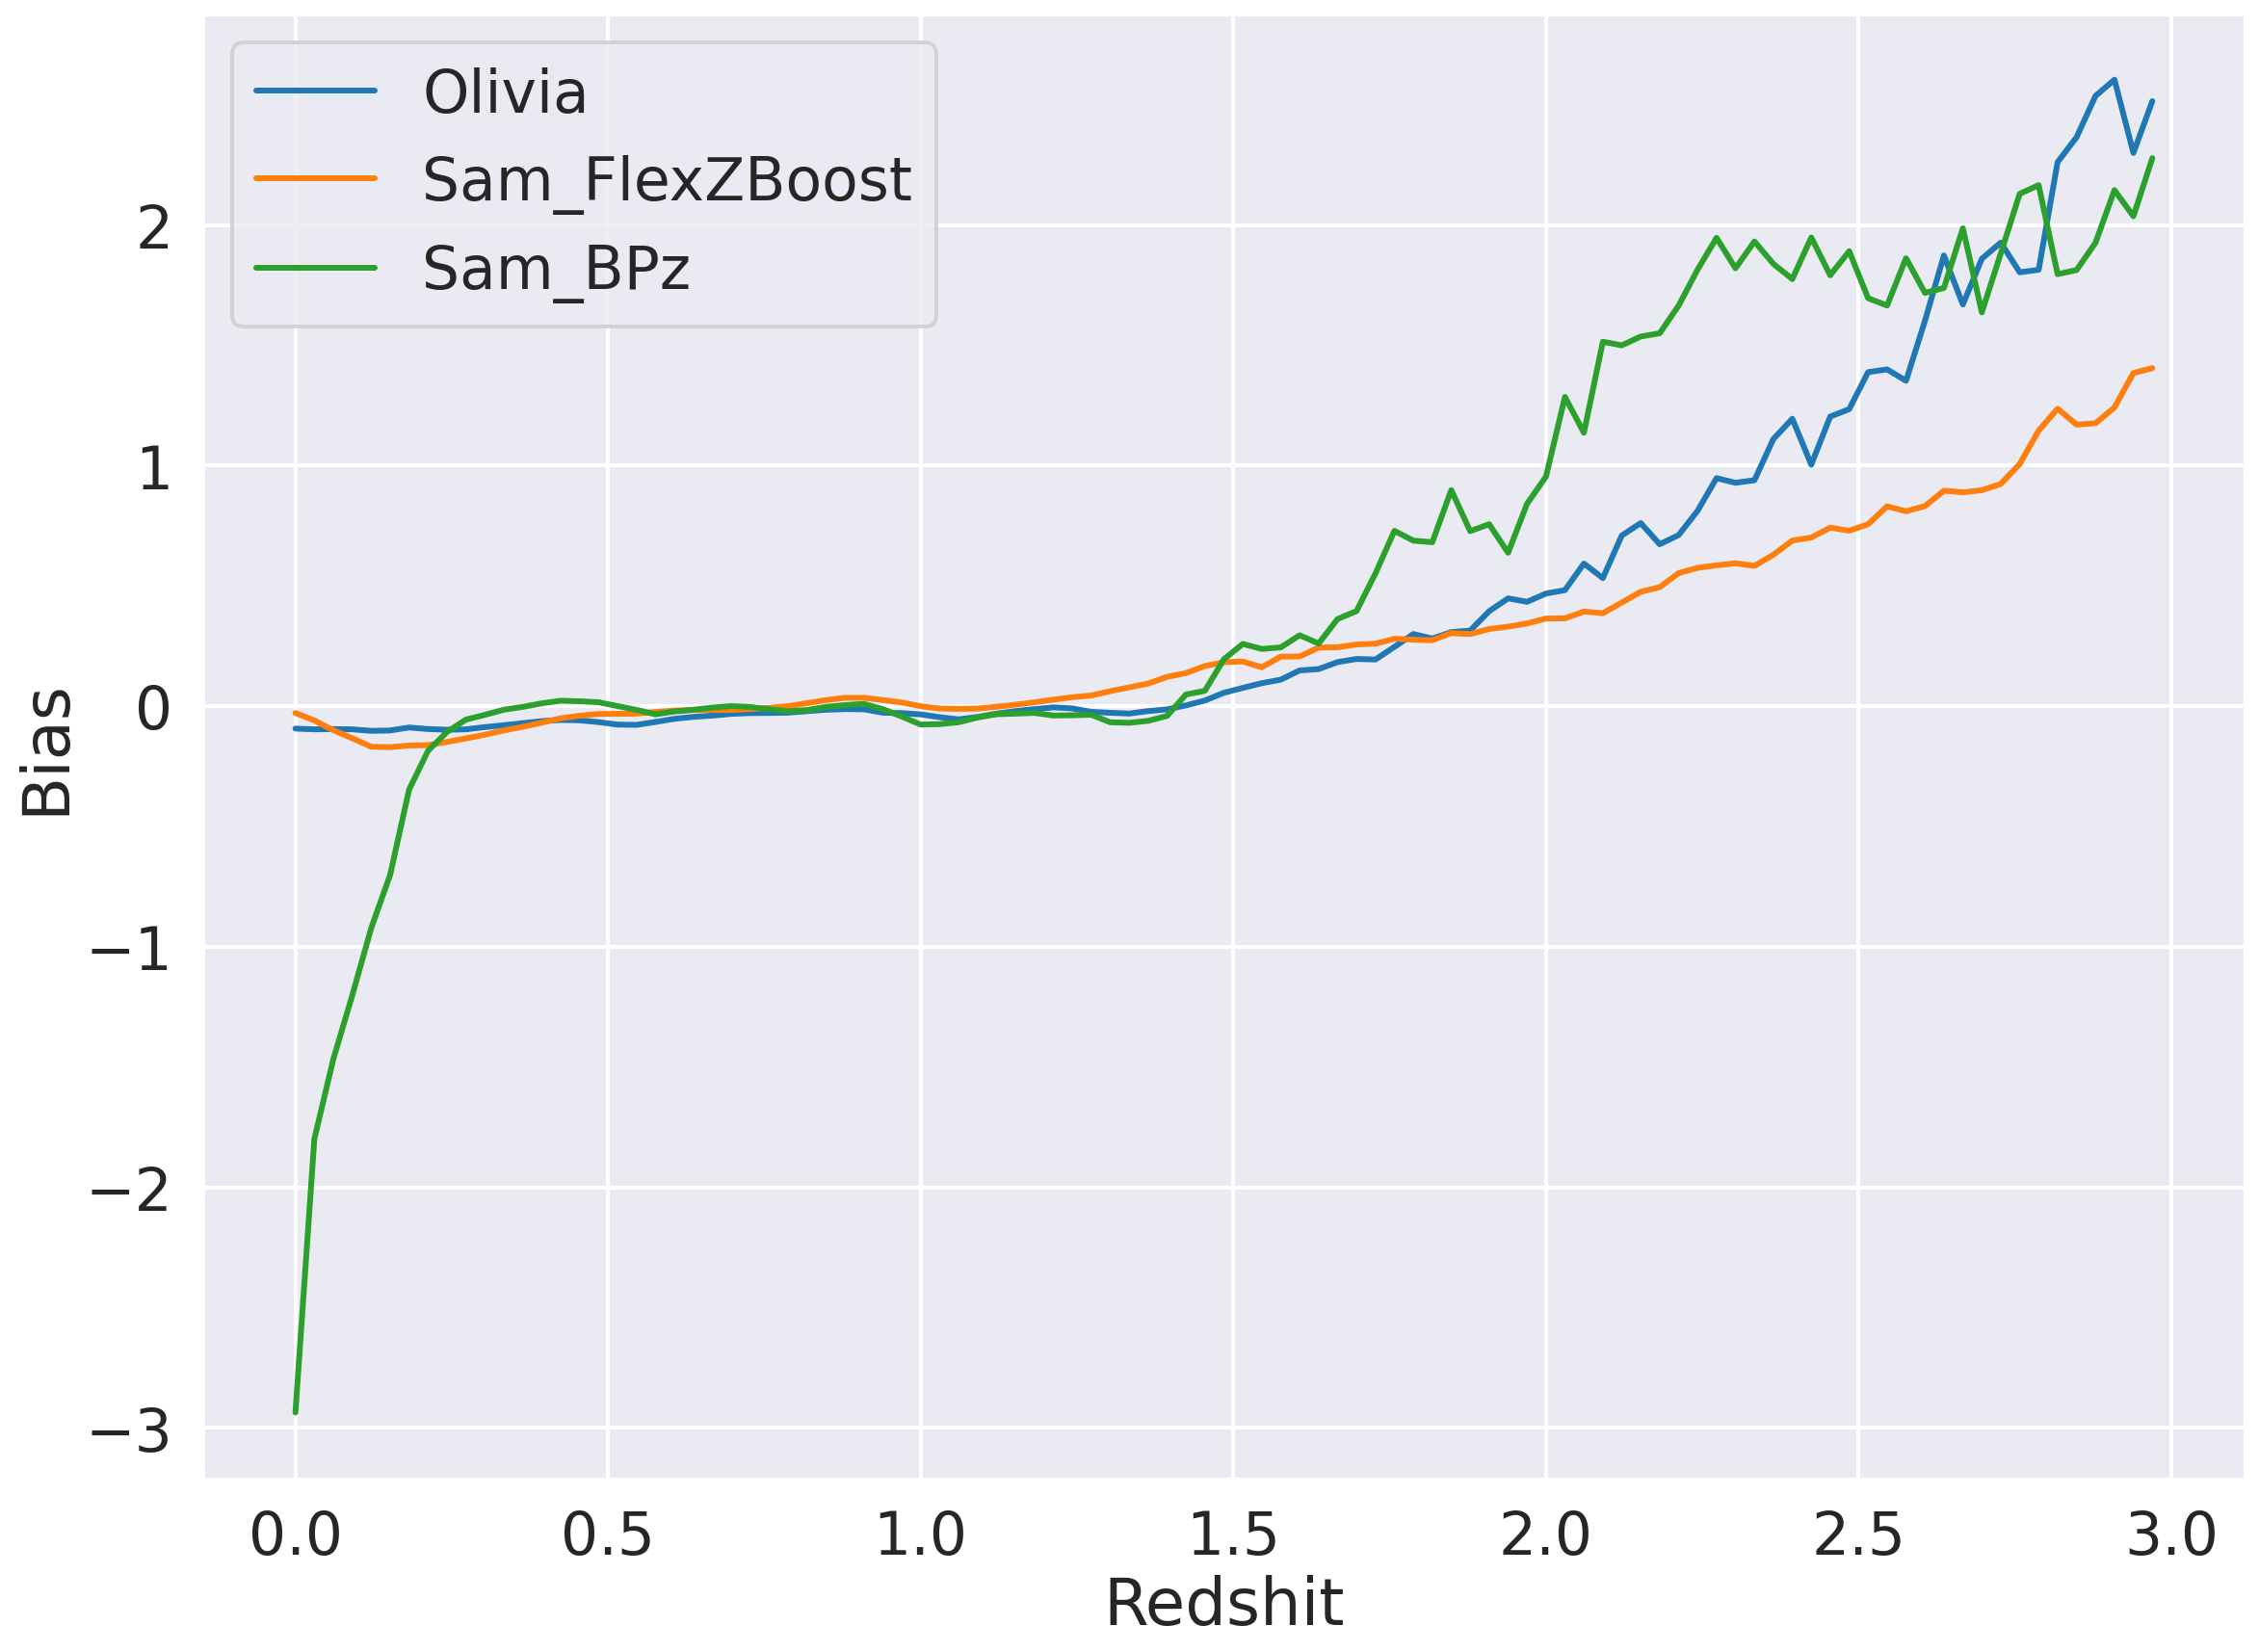

In [59]:
save = {}
edges = np.linspace(0, 3, 100)
for data in zip([df1, df2, bpz],
                ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                ['rz_real', 'redshift', 'redshift_lsst'],
                ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
    binned_data = []
    for i in range(len(edges)-1):
        df = data[0]
        data_in_bin = df[np.logical_and(df[data[2]]>edges[i], df[data[2]]<edges[i+1])] 
        binned_data.append(data_in_bin)
    x = edges[:-1]
    y = [np.mean(d[data[2]])-np.mean(d[data[3]]) for d in binned_data]
    sns.lineplot(x, y, label=data[1], markers=True)
    save[data[1]] = {'redshift':x, 'bias':y}
plt.ylabel('Bias')
plt.xlabel('Redshit')
plt.legend()

pickle.dump(save, open('bias.p', 'wb'))

## Standard Deviation

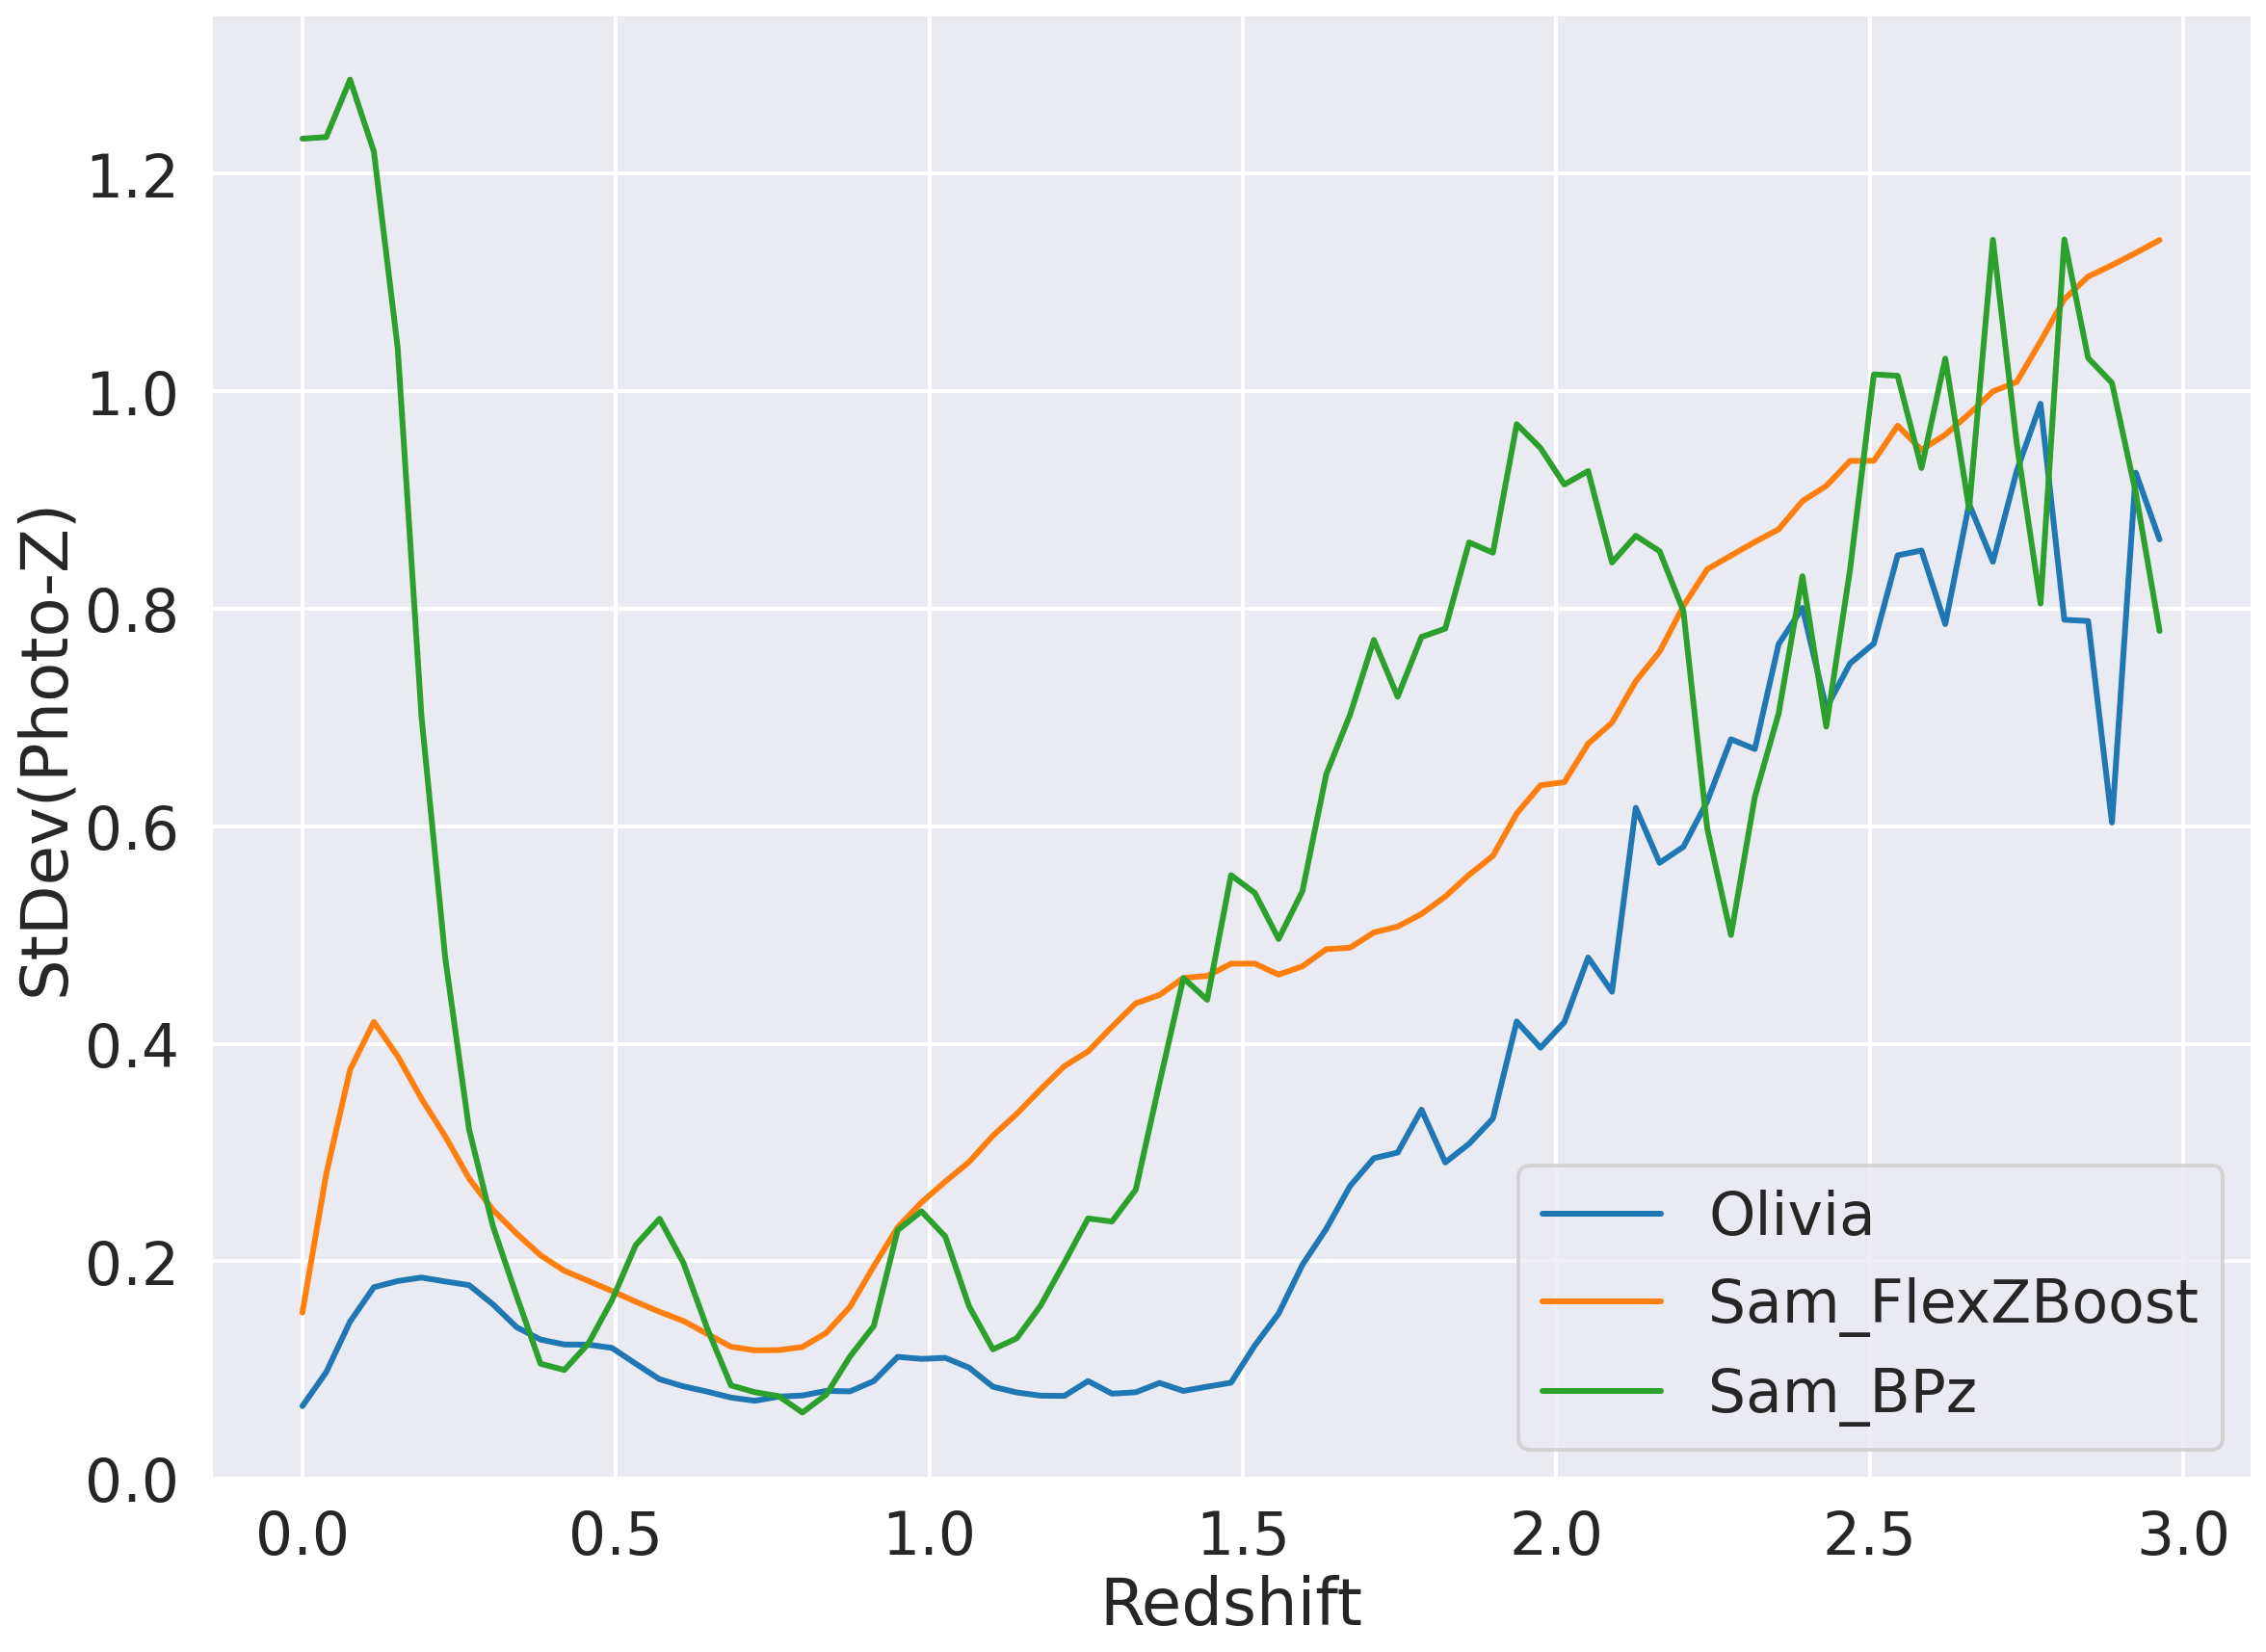

In [58]:
save = {}
edges = np.linspace(0, 3, 80)
for data in zip([df1, df2, bpz],
                ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                ['rz_real', 'redshift', 'redshift_lsst'],
                ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
    binned_data = []
    y = []
    for i in range(len(edges)-1):
        df = data[0]
        data_in_bin = df[np.logical_and(df[data[2]]>edges[i], df[data[2]]<edges[i+1])] 
        binned_data.append(data_in_bin)
        y.append(np.std(data_in_bin[data[3]]))
    x =  edges[:-1]
    sns.lineplot(x, y, label=data[1], markers=True)
    save[data[1]] = {'redshift':x, 'scatter':y}
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('StDev(Photo-Z)')
pickle.dump(save, open('scatter.p', 'wb'))

## Outlier Fraction

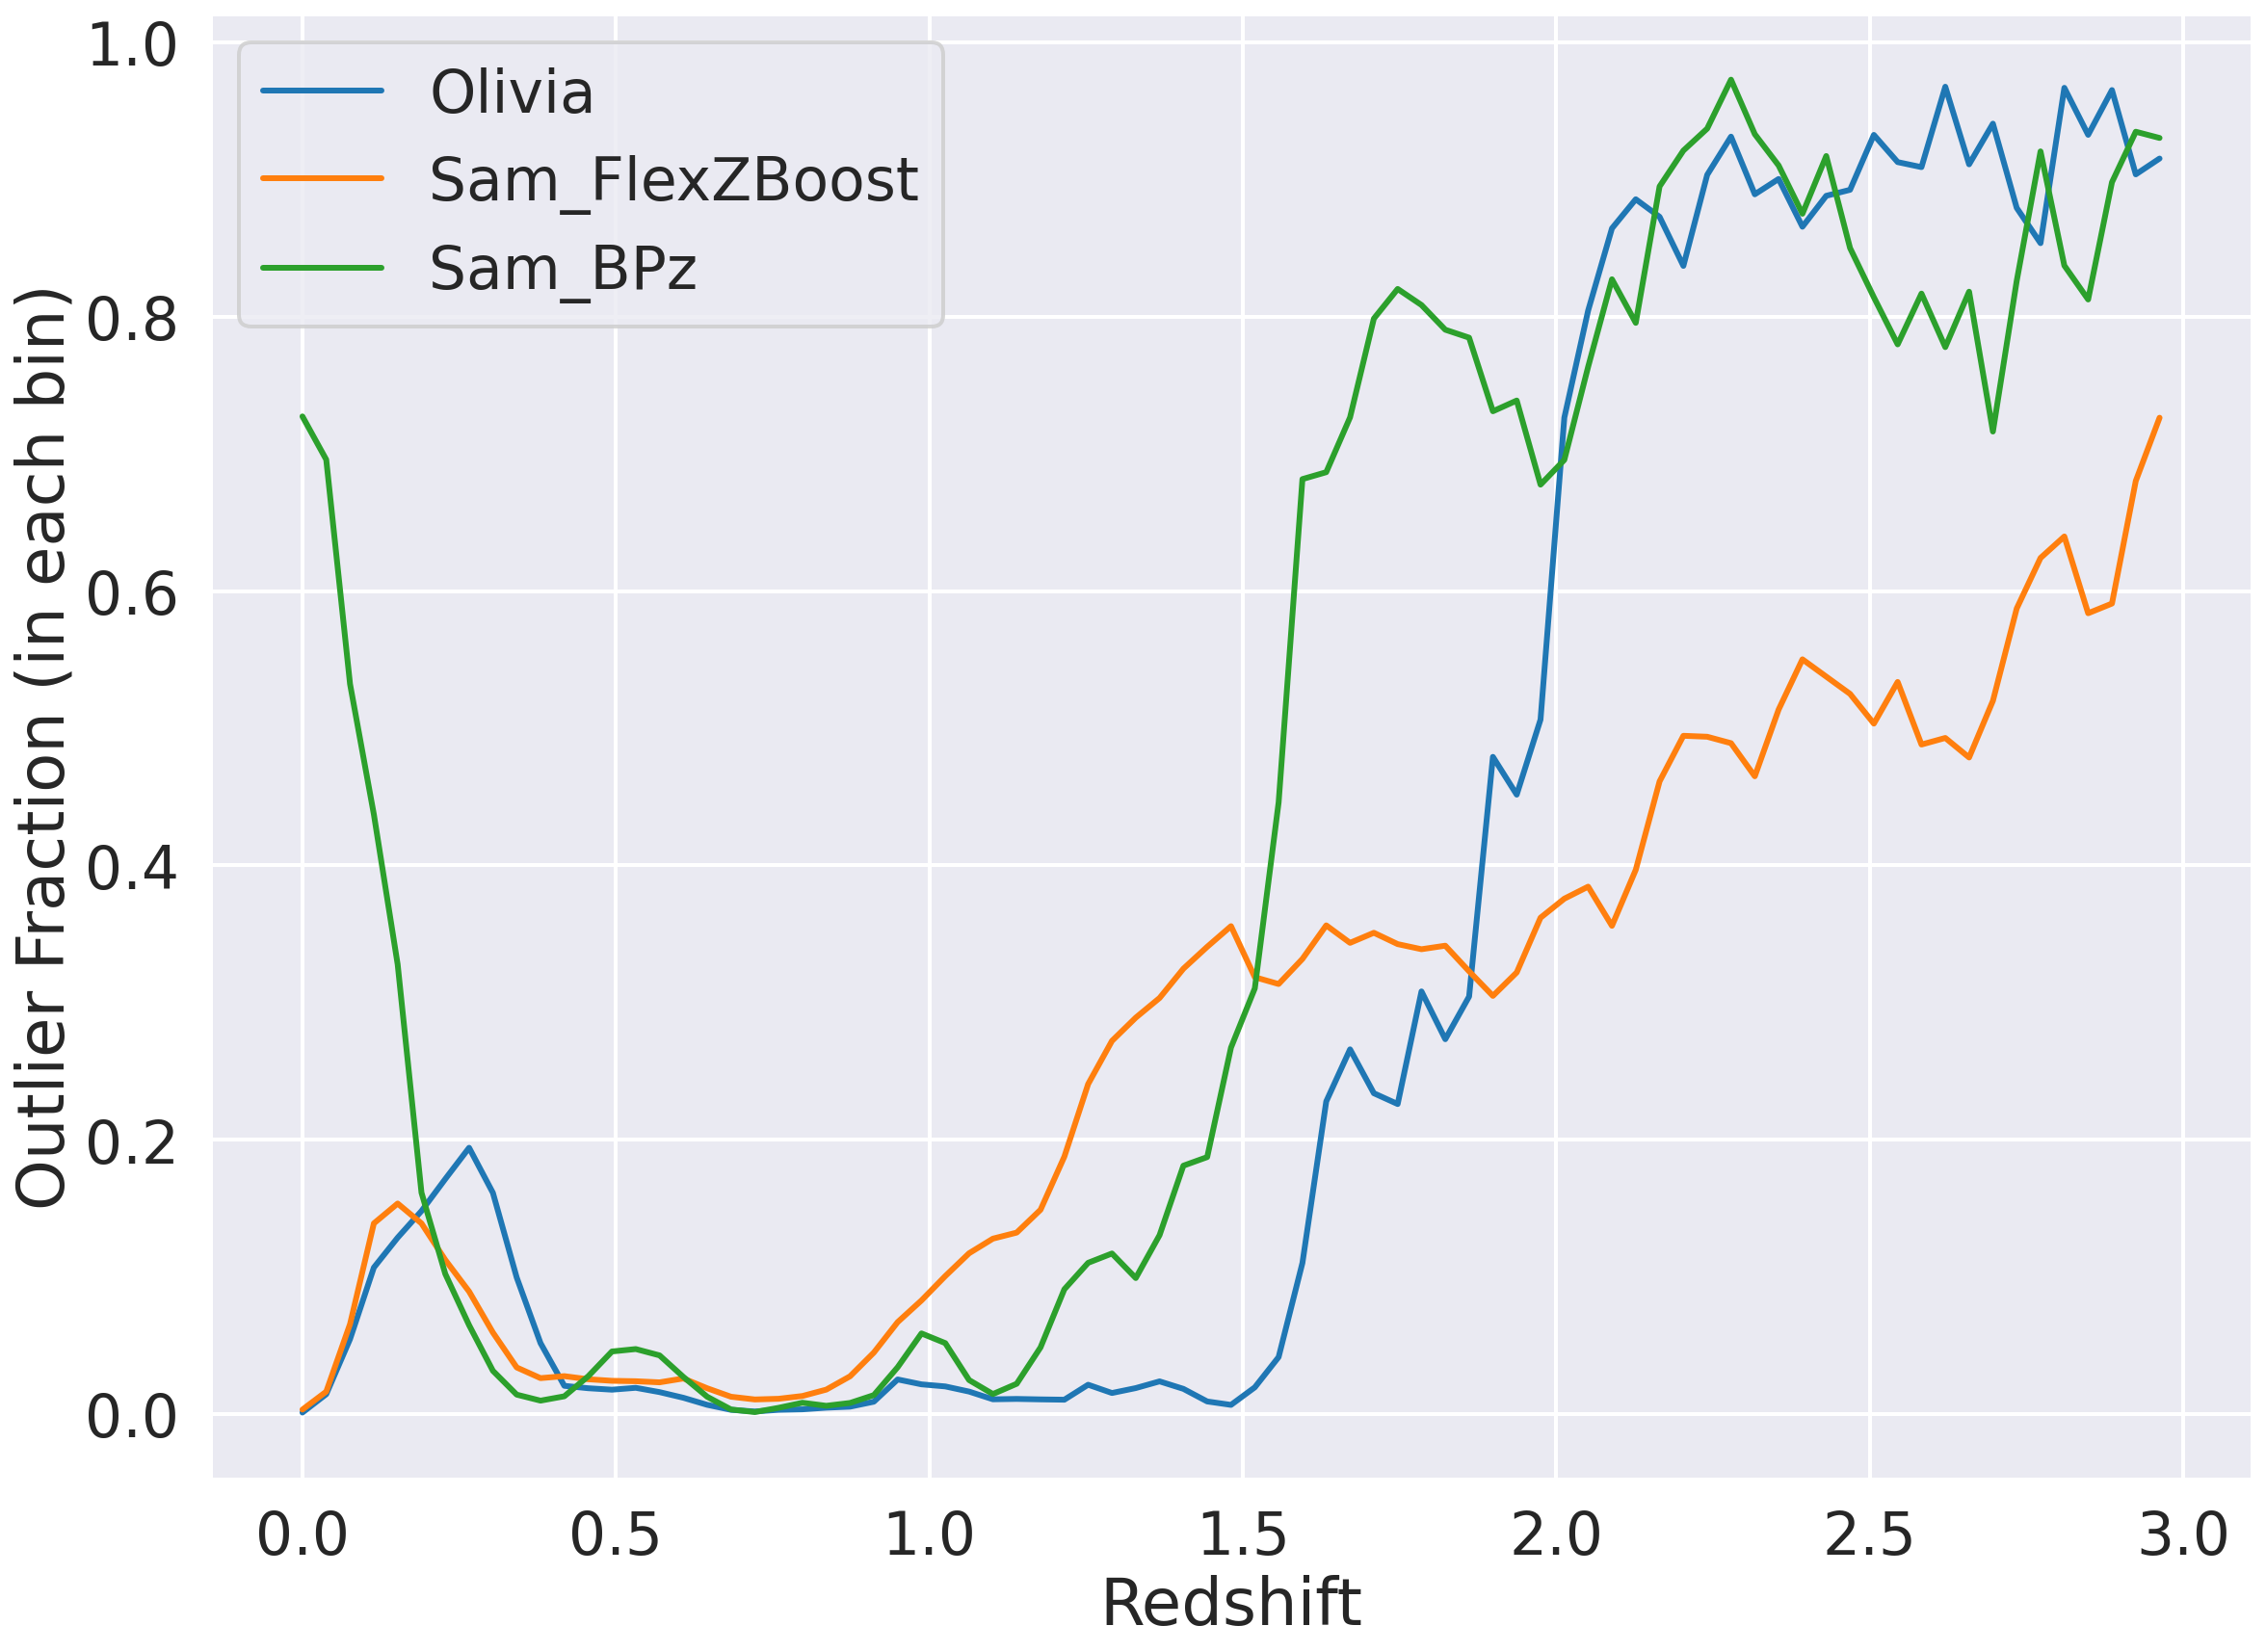

In [57]:
save = {}
edges = np.linspace(0, 3, 80)
for data in zip([df1, df2, bpz],
                ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                ['rz_real', 'redshift', 'redshift_lsst'],
                ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
    binned_data, y = [], []
    for i in range(len(edges)-1):
        df = data[0]
        data_in_bin = df[np.logical_and(df[data[2]]>edges[i], df[data[2]]<edges[i+1])] 
        errors = data_in_bin[data[2]] - data_in_bin[data[3]]
        outliers = np.abs(data_in_bin[data[2]] - data_in_bin[data[3]]) > 3 * iqr(df[data[2]] - df[data[3]])
        try:
            outlier_fraction = len(outliers[outliers==True])/(len(outliers))
        except ZeroDivisionError:
            outlier_fraction = 0
        y.append(outlier_fraction)
    x =  edges[:-1]
    sns.lineplot(x, y, label=data[1], markers=True)
    save[data[1]] = {'redshift':x, 'outlier_fraction':y}
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction (in each bin)')
pickle.dump(save, open('outlier_frac.p', 'wb'))

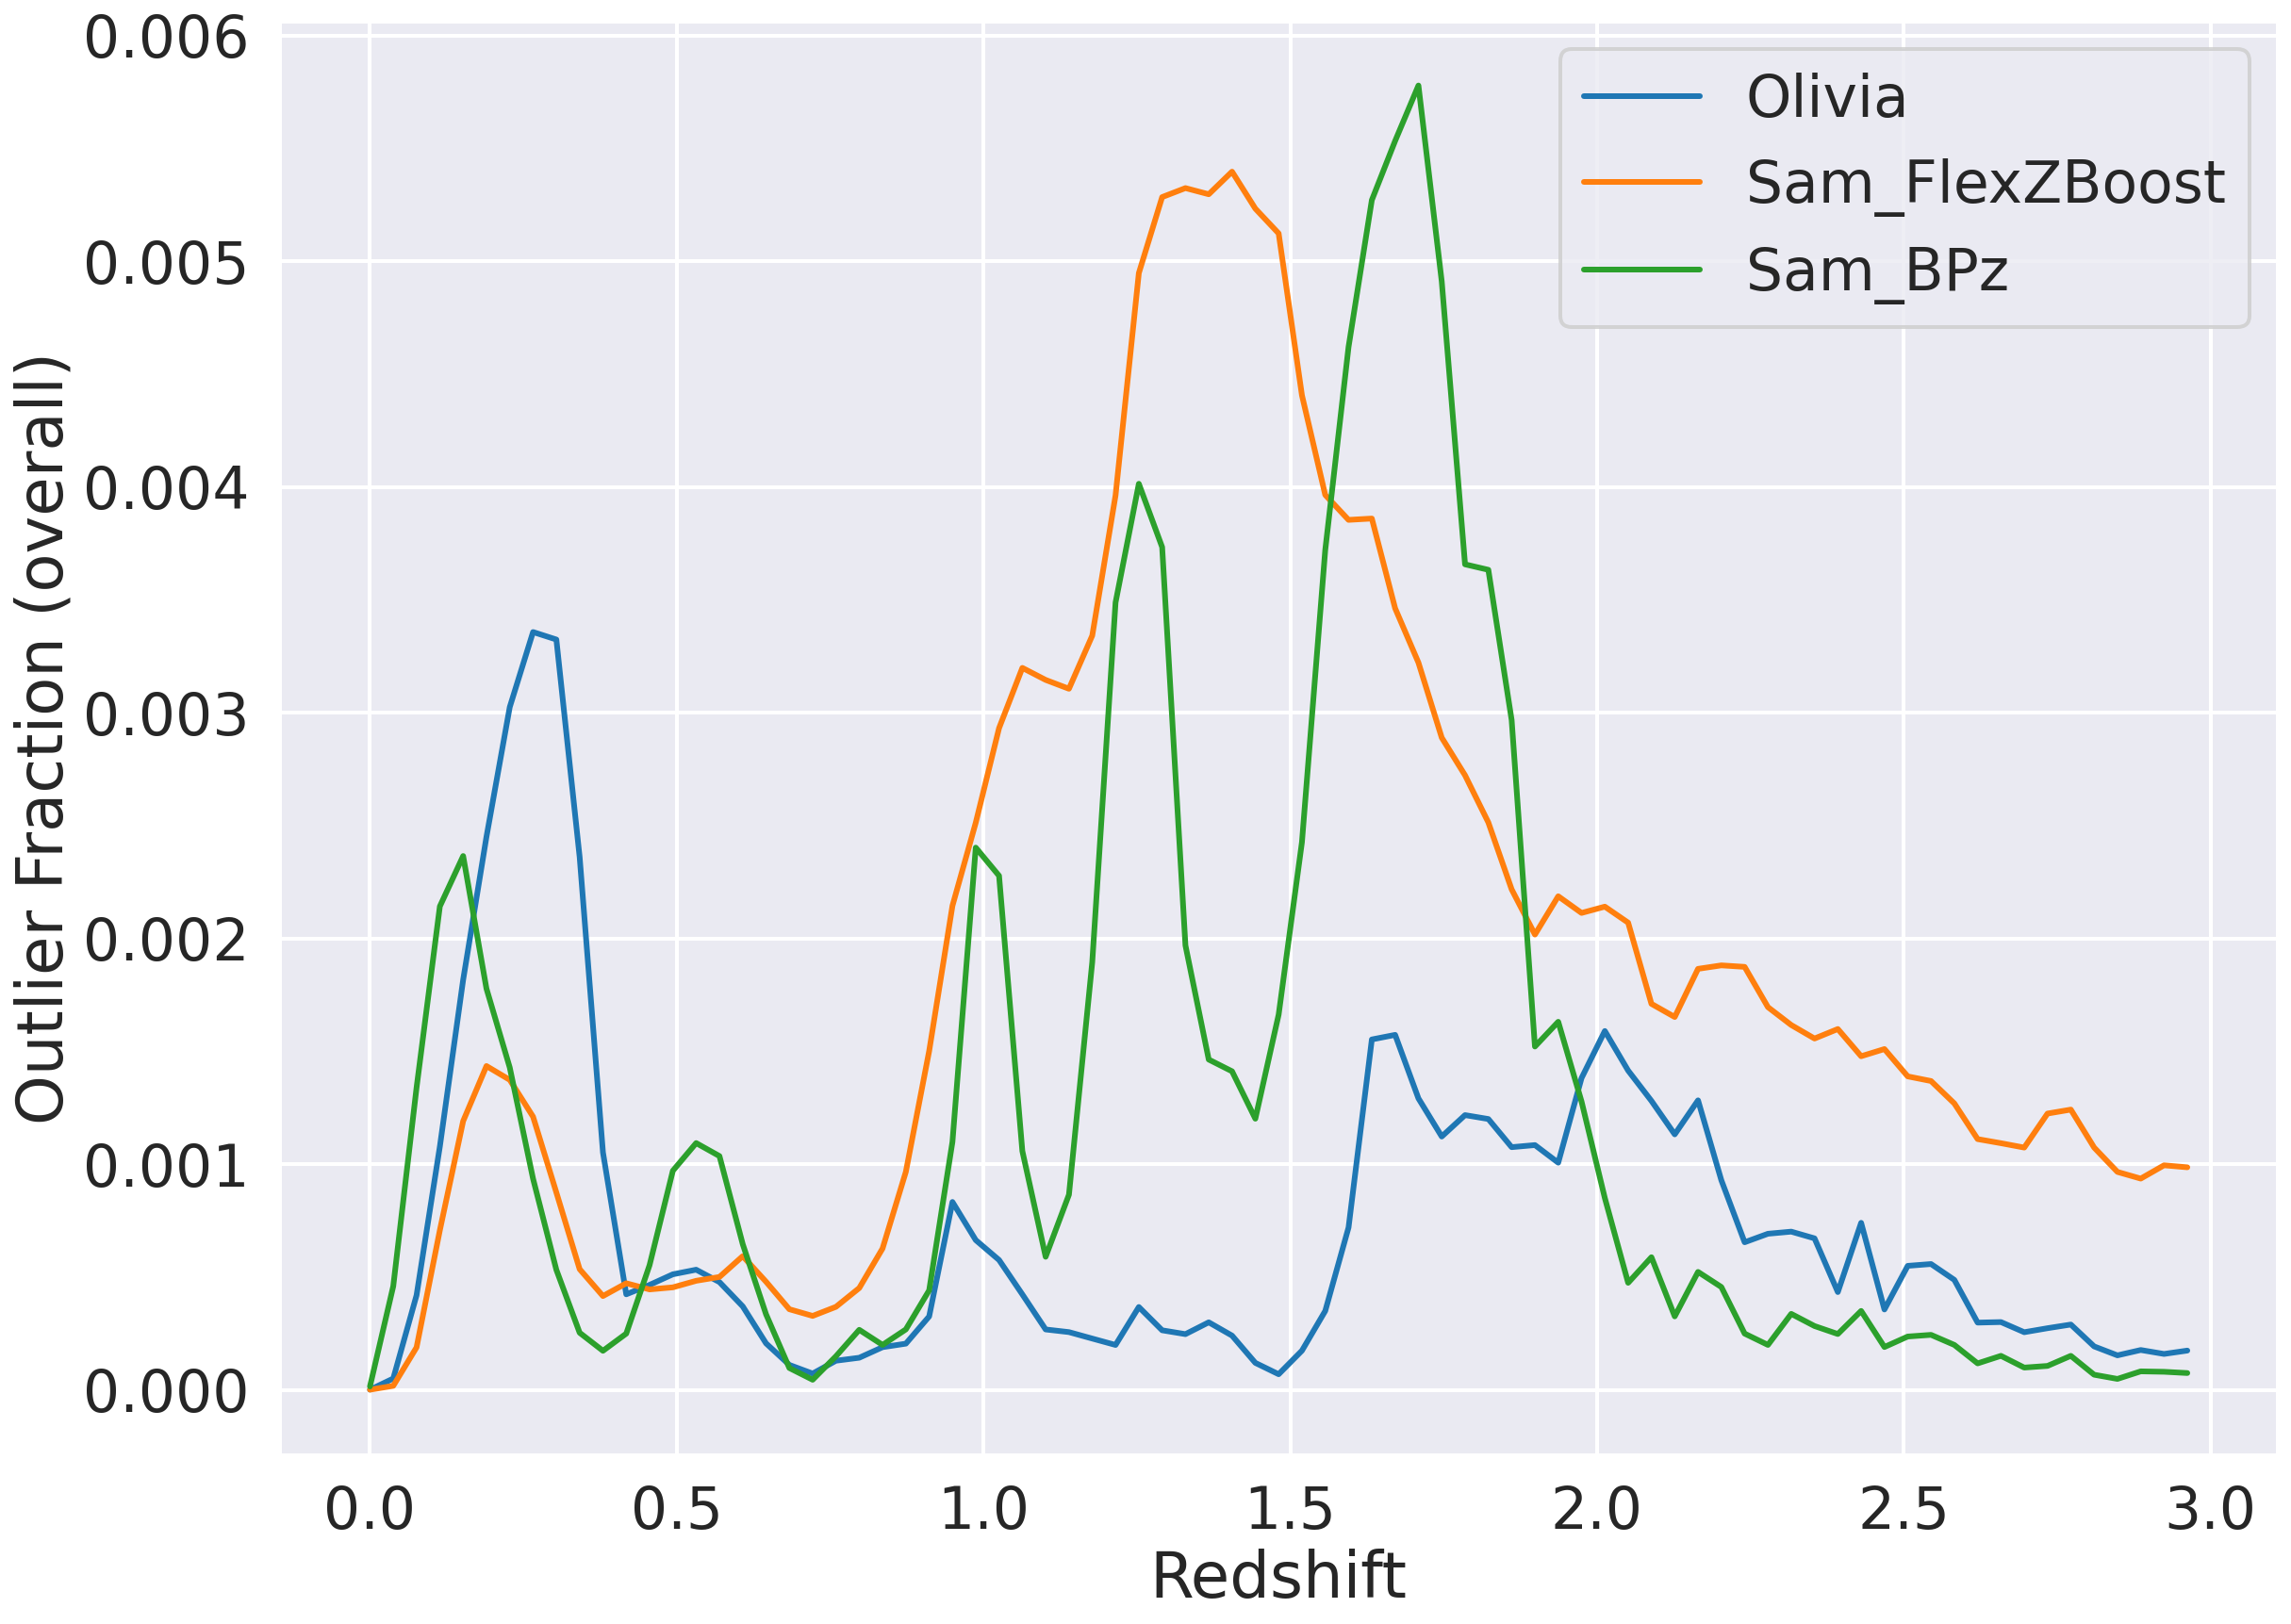

In [56]:
save = {}
edges = np.linspace(0, 3, 80)
for data in zip([df1, df2, bpz],
                ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                ['rz_real', 'redshift', 'redshift_lsst'],
                ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
    binned_data, y = [], []
    for i in range(len(edges)-1):
        df = data[0]
        data_in_bin = df[np.logical_and(df[data[2]]>edges[i], df[data[2]]<edges[i+1])] 
        errors = data_in_bin[data[2]] - data_in_bin[data[3]]
        outliers = np.abs(data_in_bin[data[2]] - data_in_bin[data[3]]) > 3 * iqr(df[data[2]] - df[data[3]])
        try:
            outlier_fraction = len(outliers[outliers==True])/(len(df))
        except ZeroDivisionError:
            outlier_fraction = 0
        y.append(outlier_fraction)
    x =  edges[:-1]
    sns.lineplot(x, y, label=data[1], markers=True)
    save[data[1]] = {'redshift':x, 'outlier_fraction':y}
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction (overall)')
pickle.dump(save, open('outlier_frac_df.p', 'wb'))

## Kernel Density Estimation of Outliers

Titles of plots correspond to the redshift bins

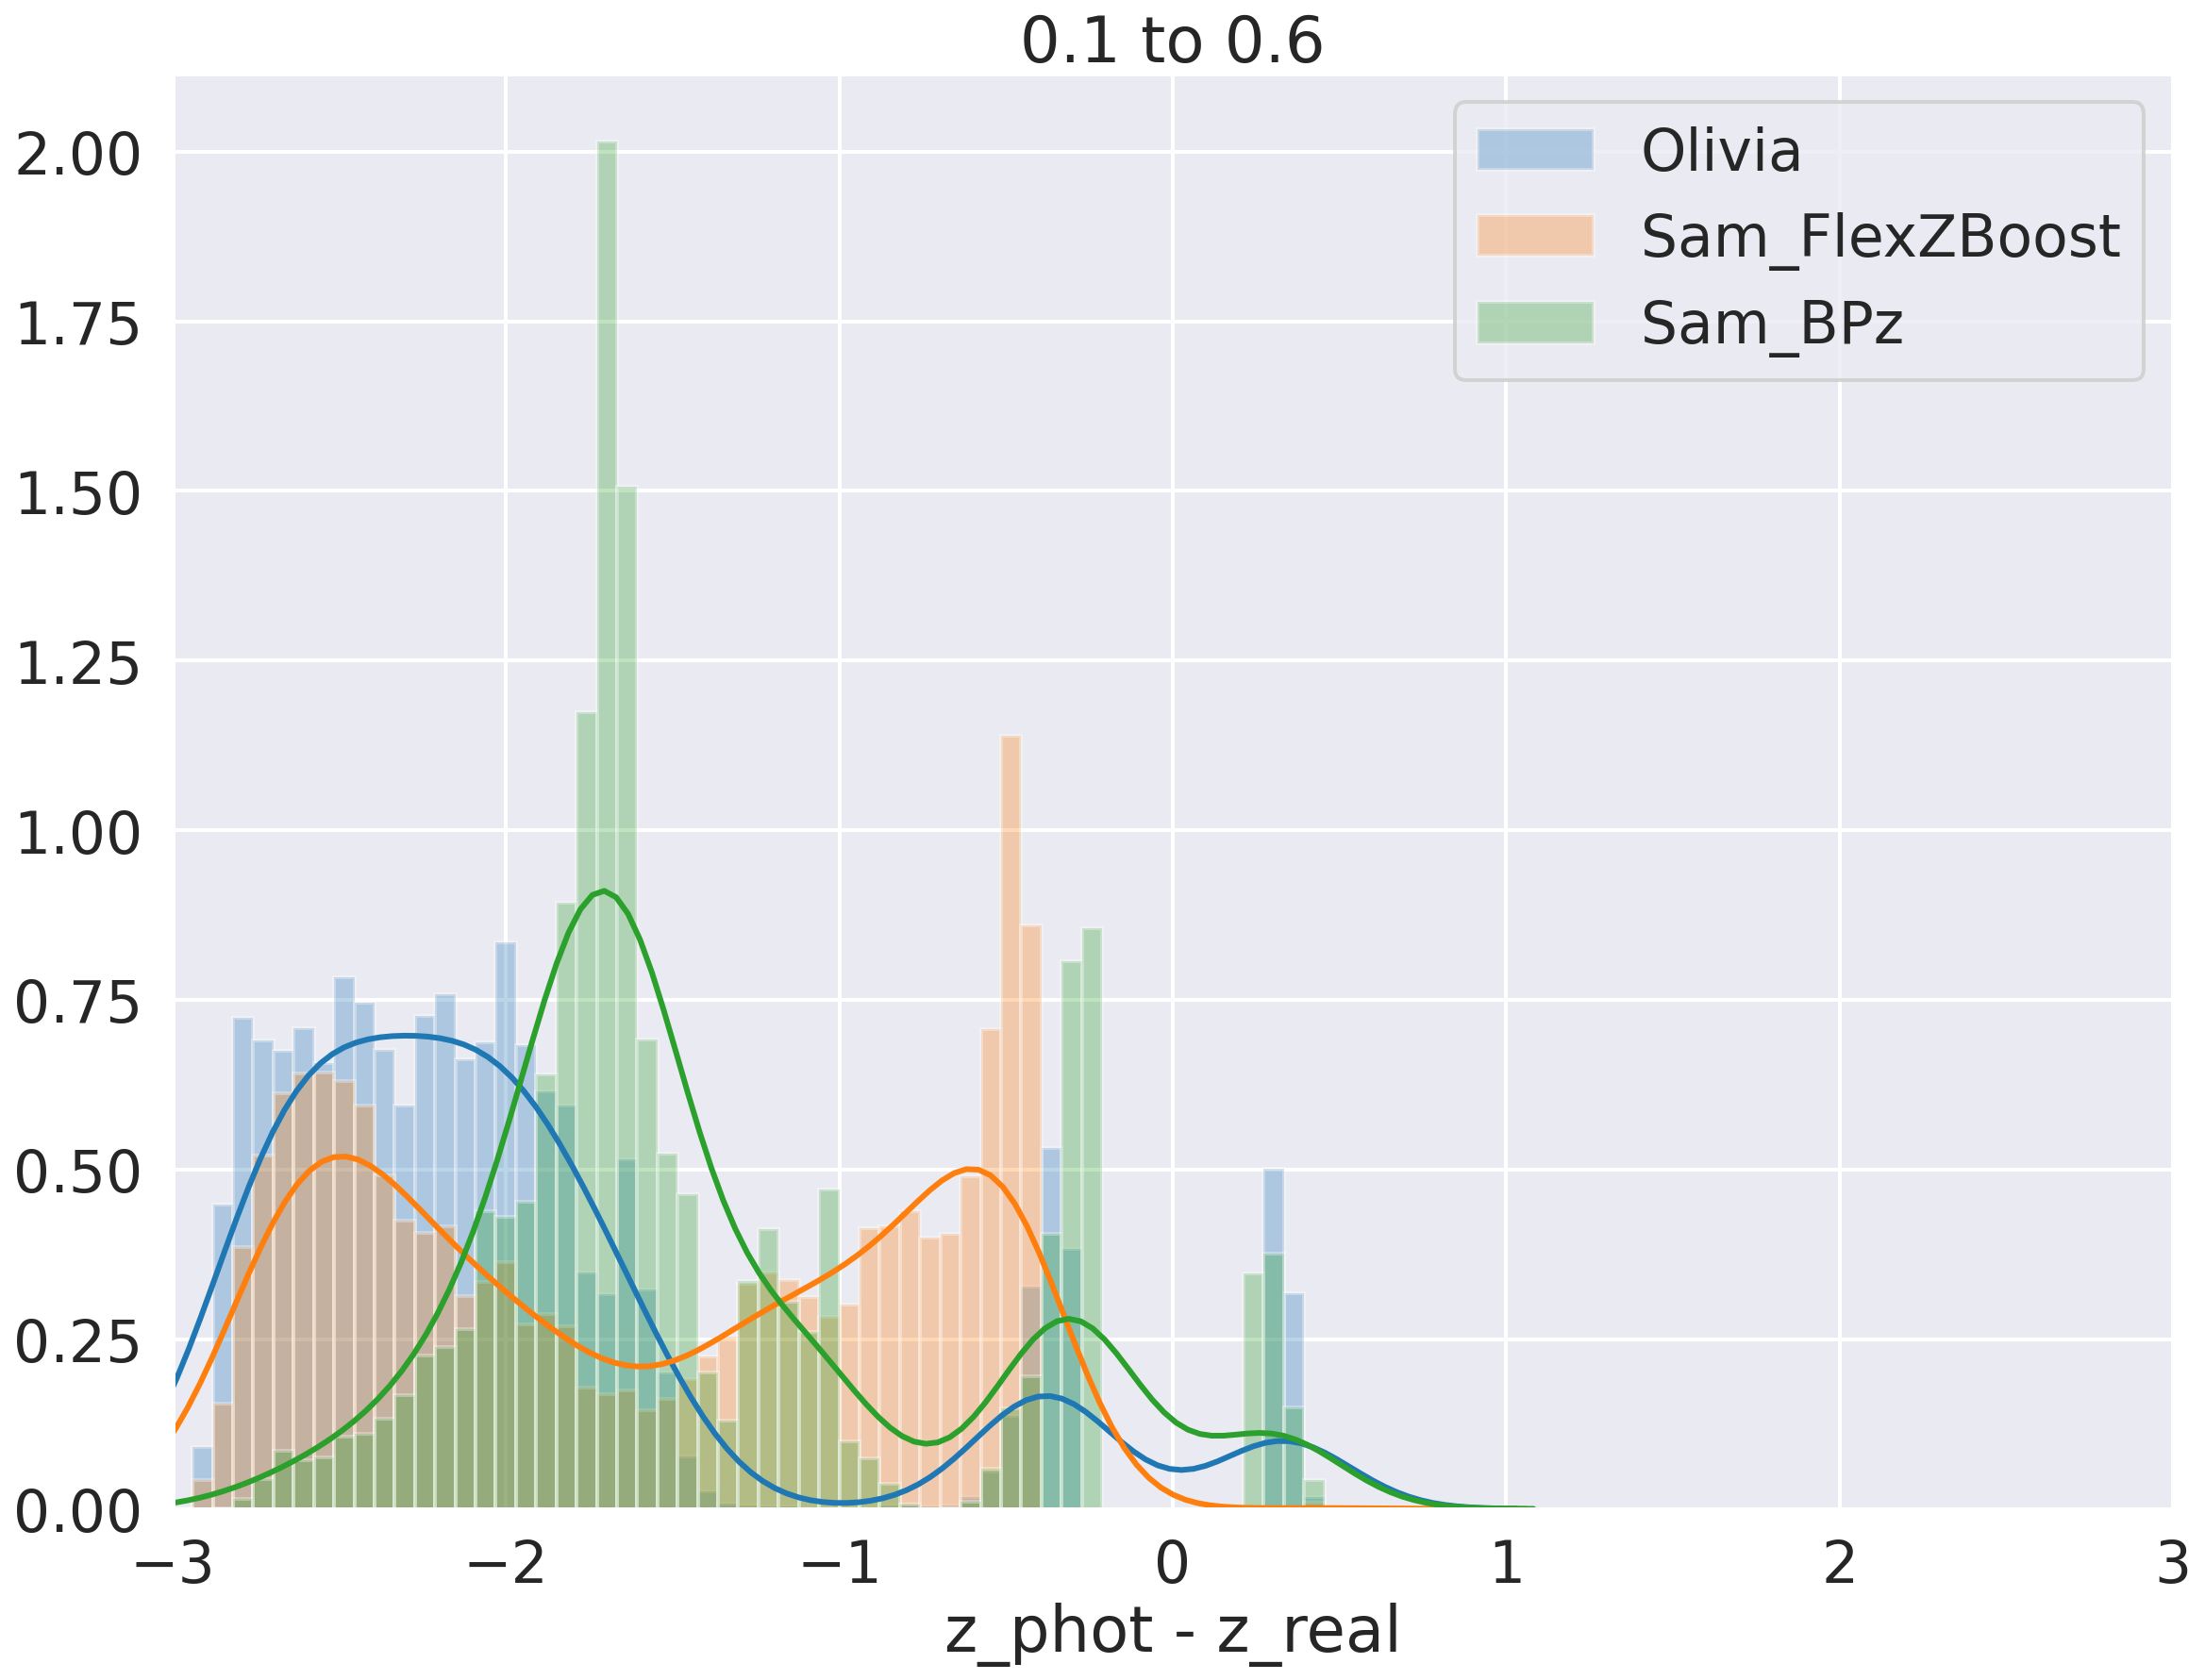

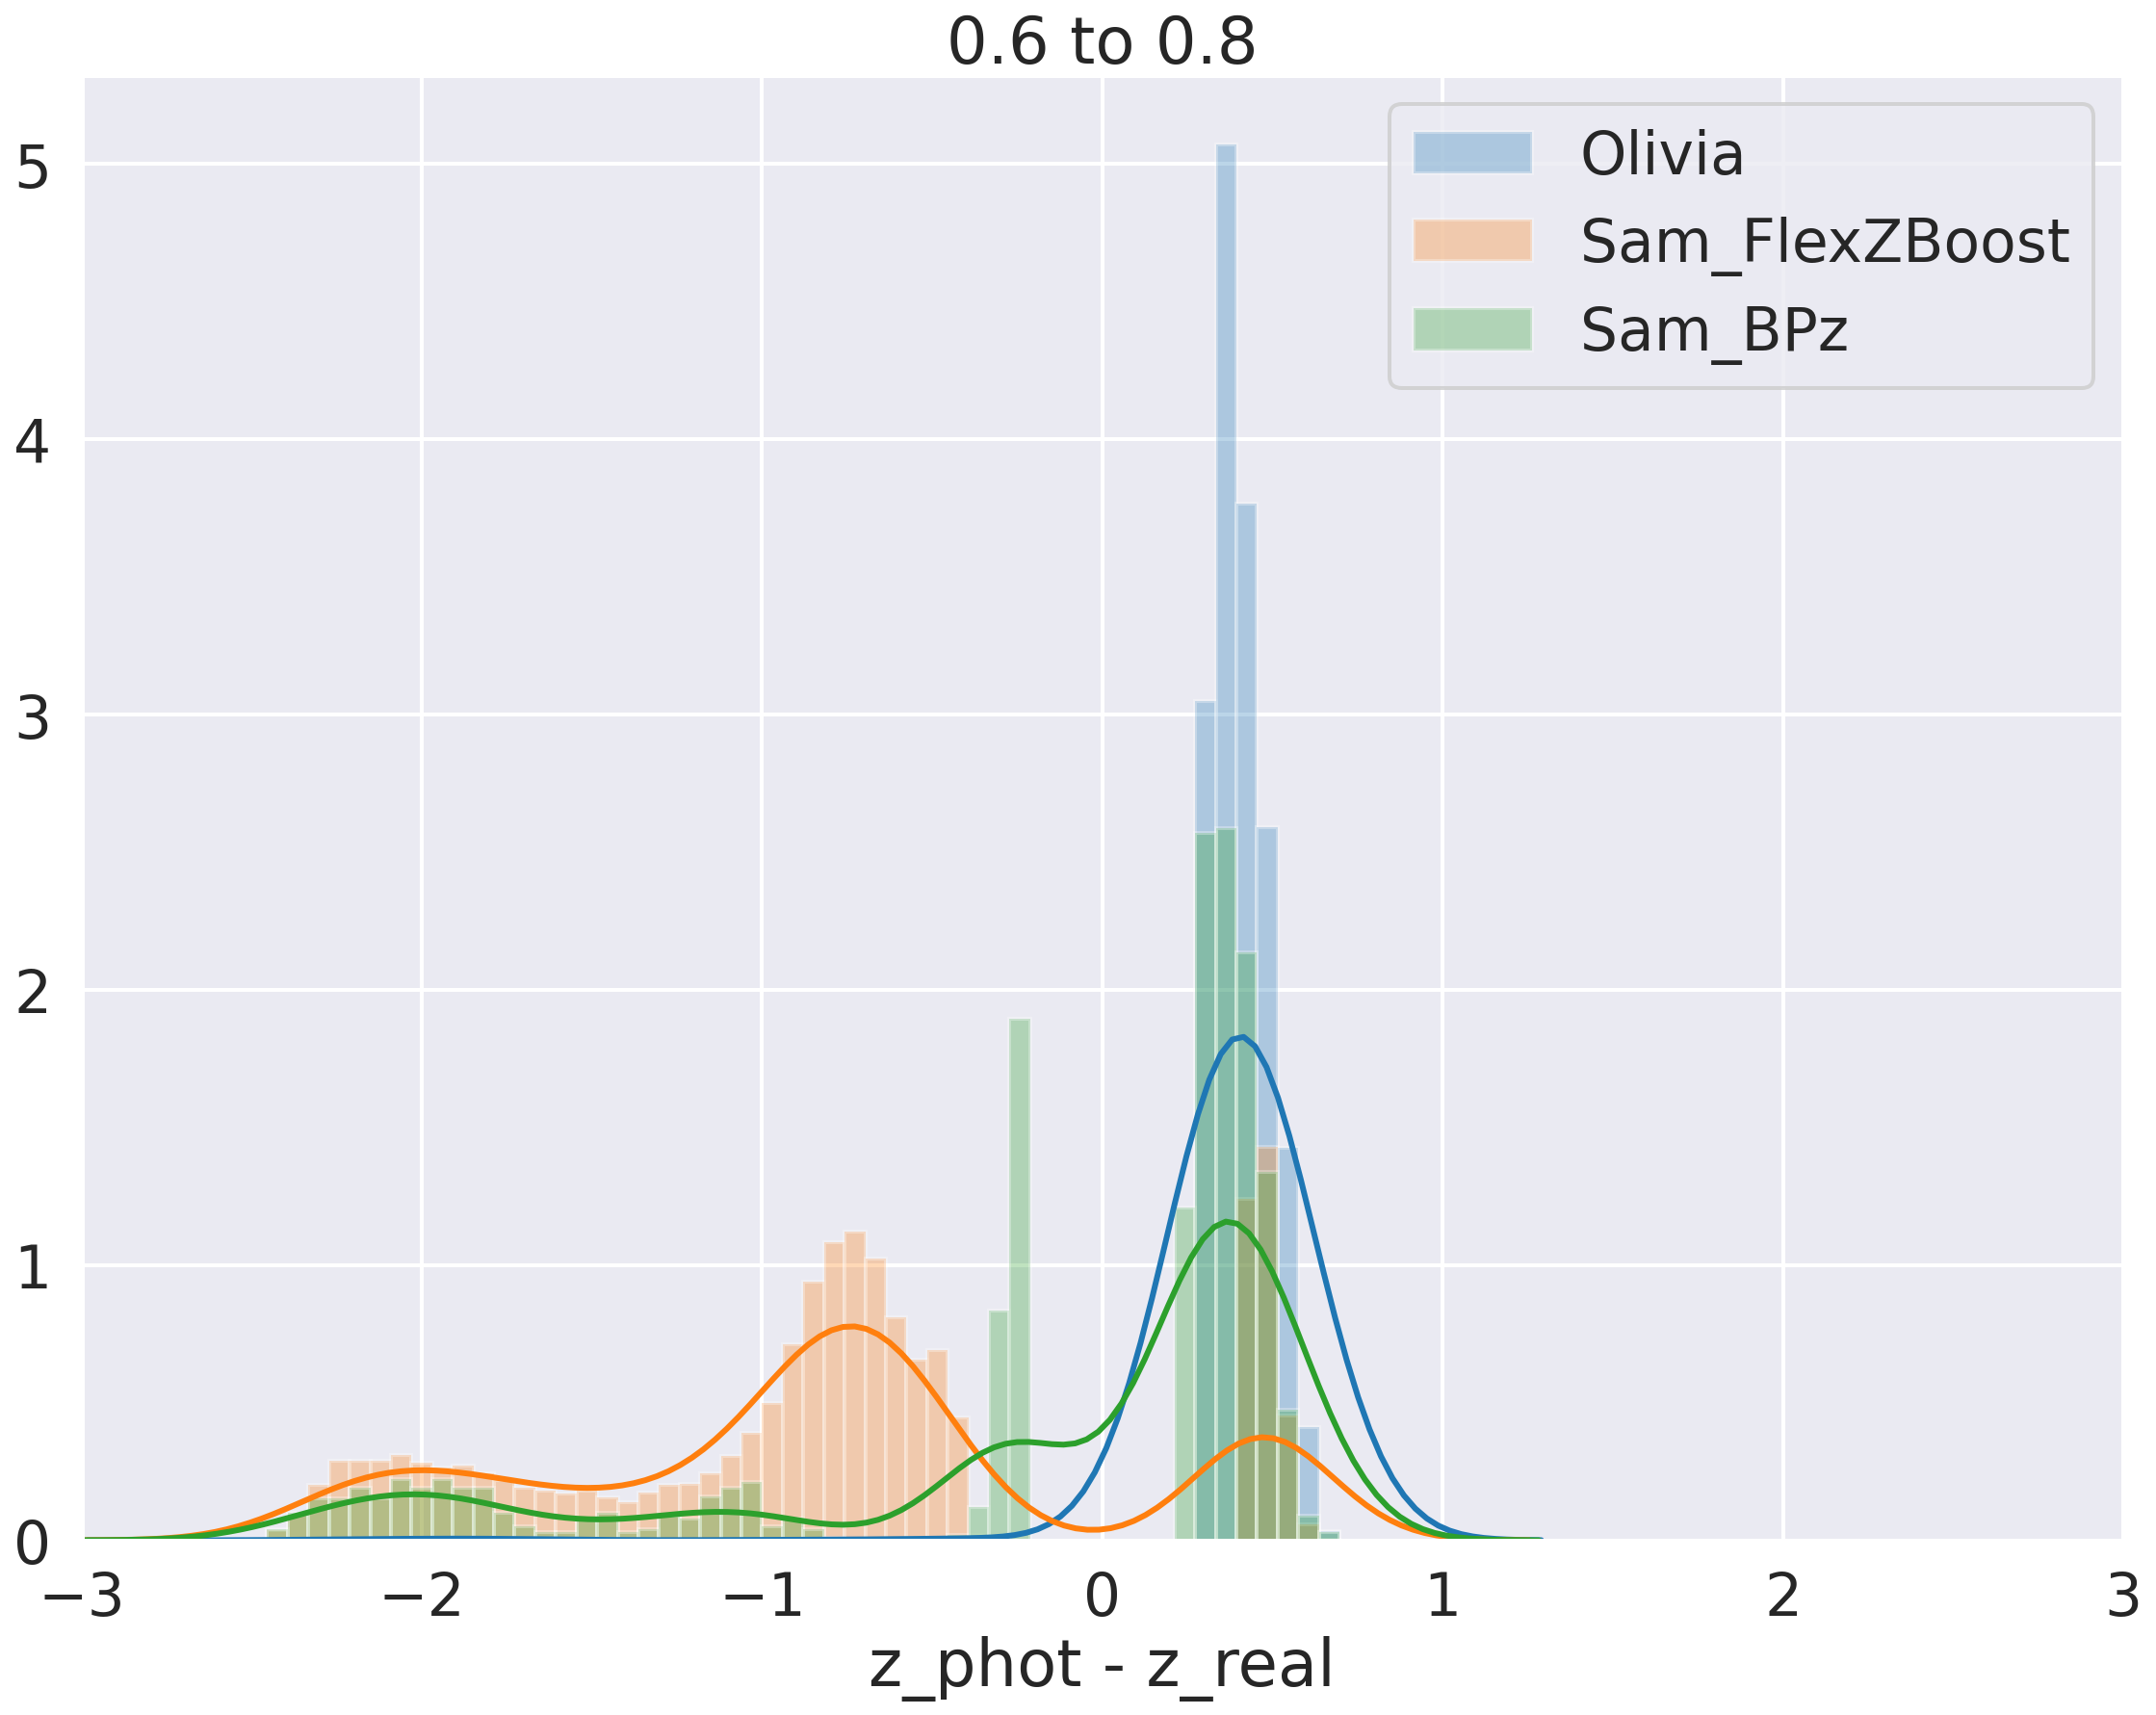

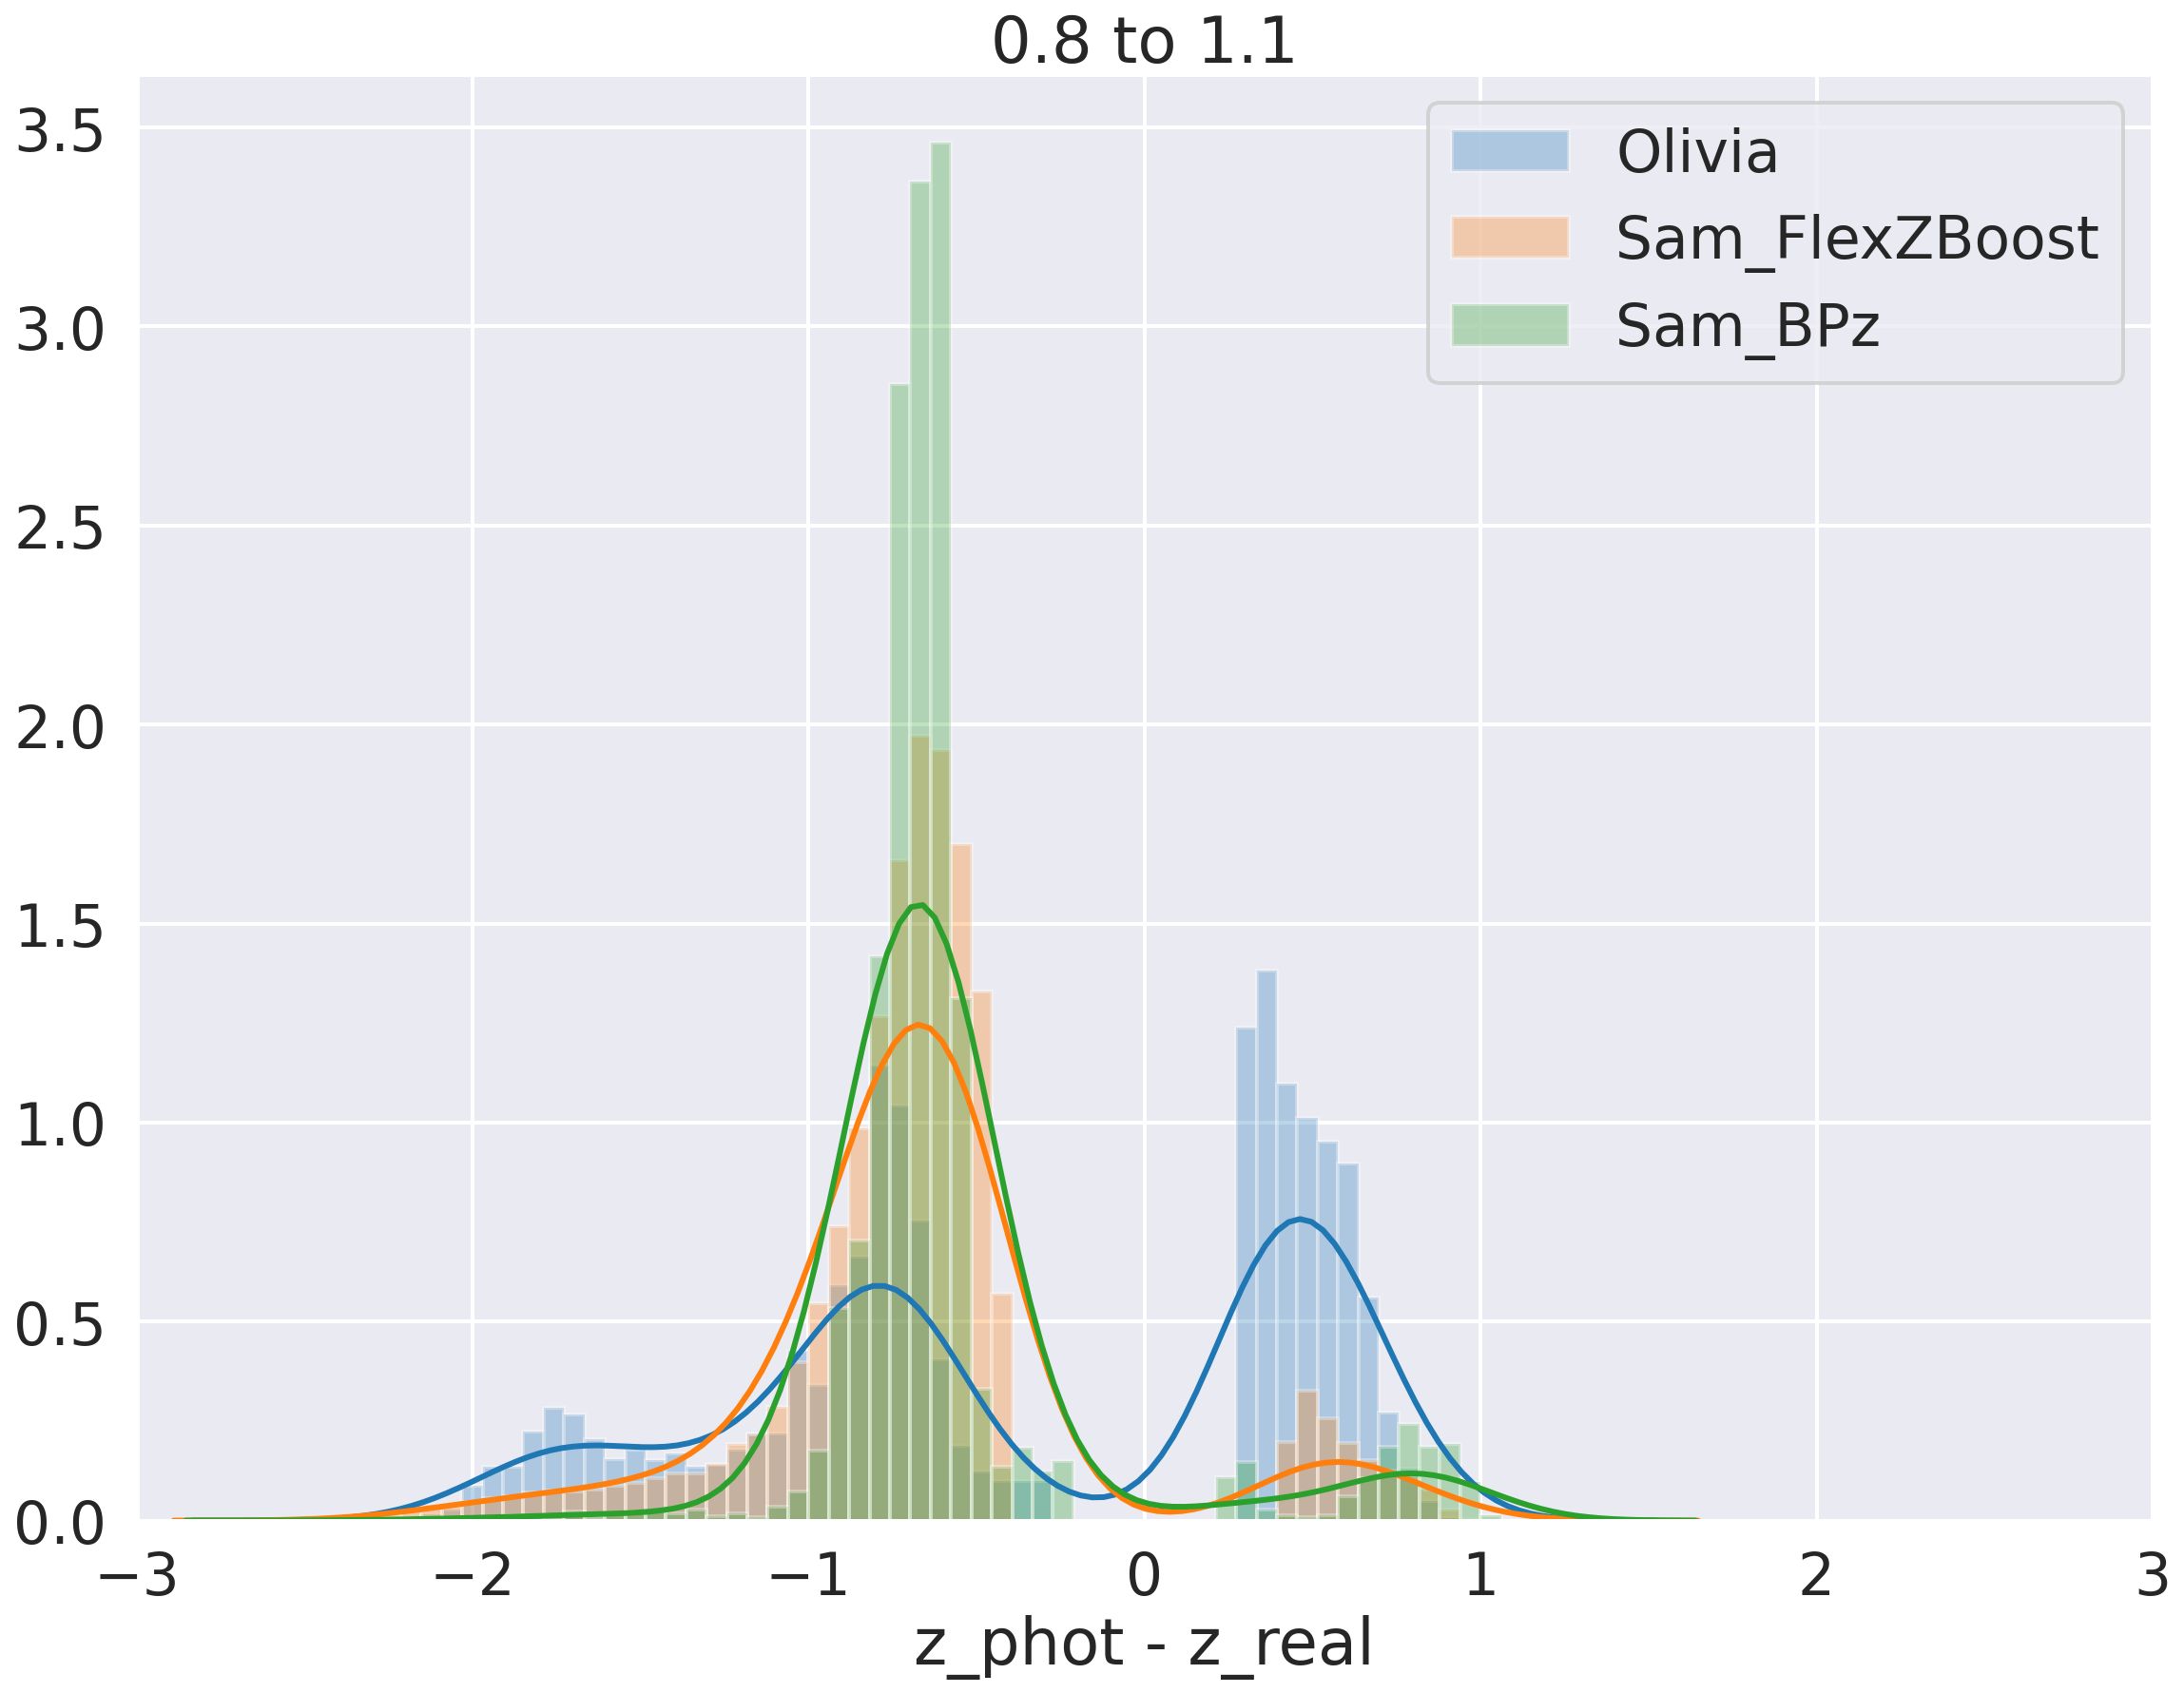

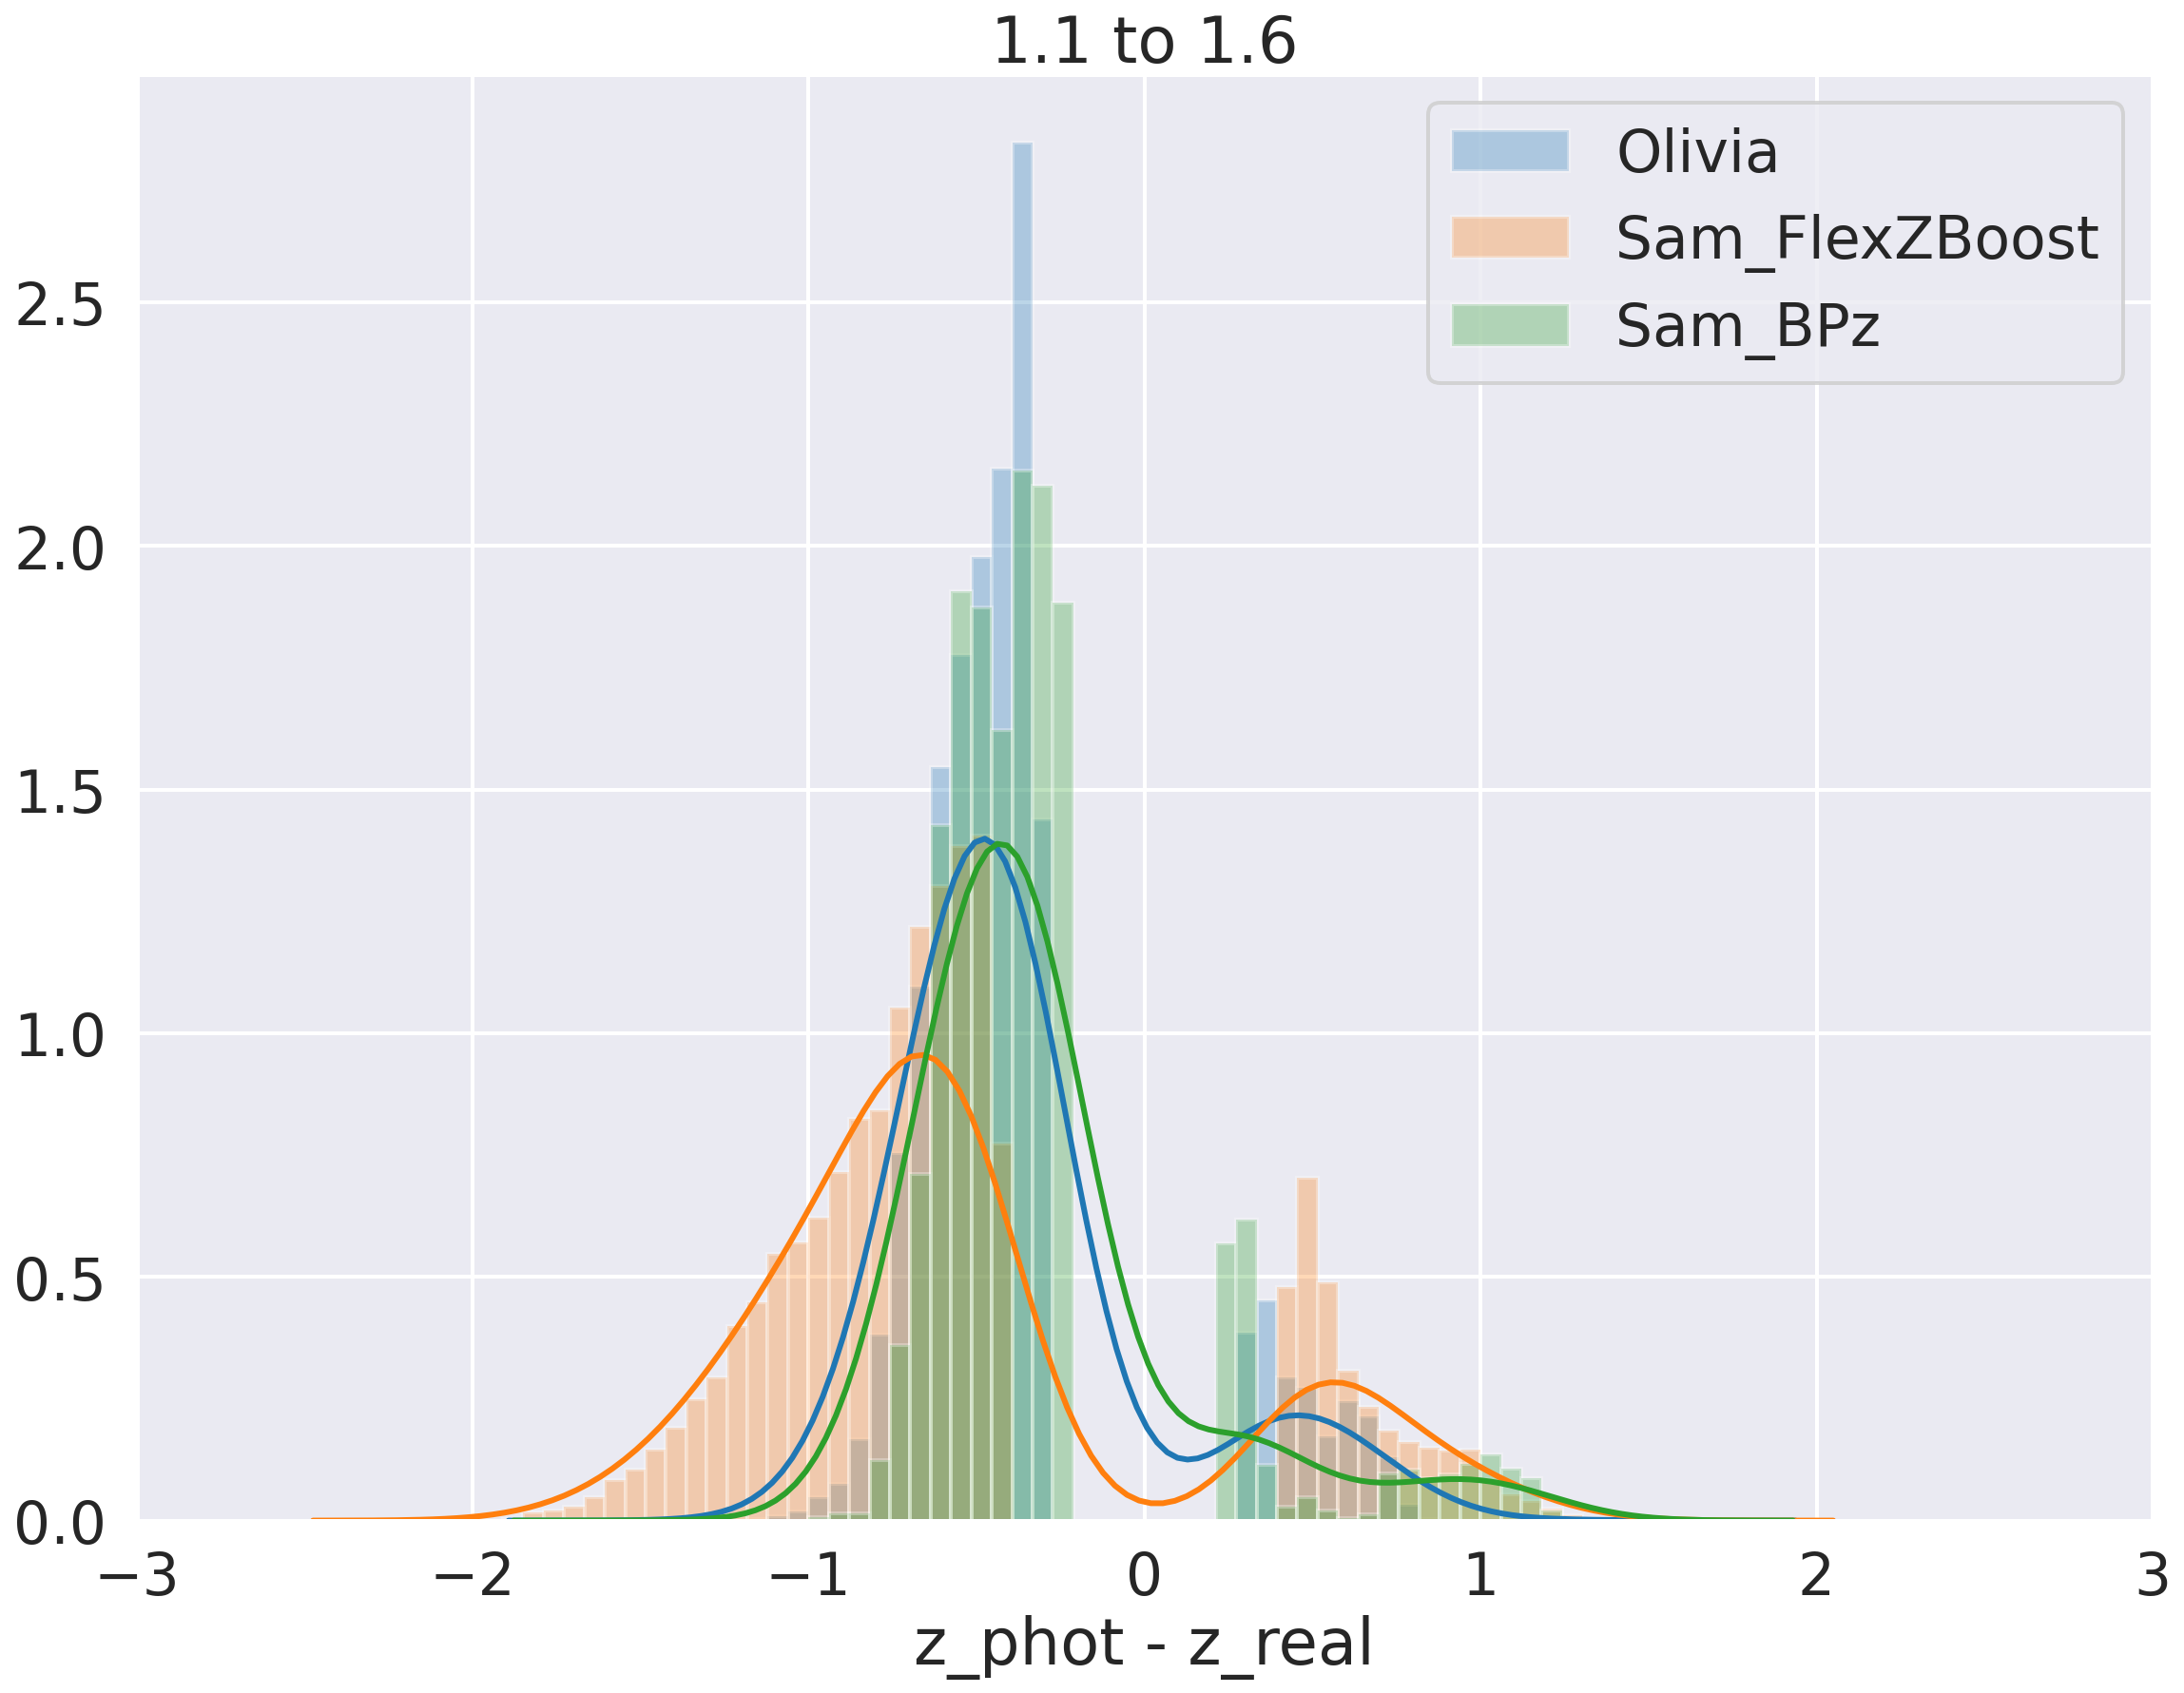

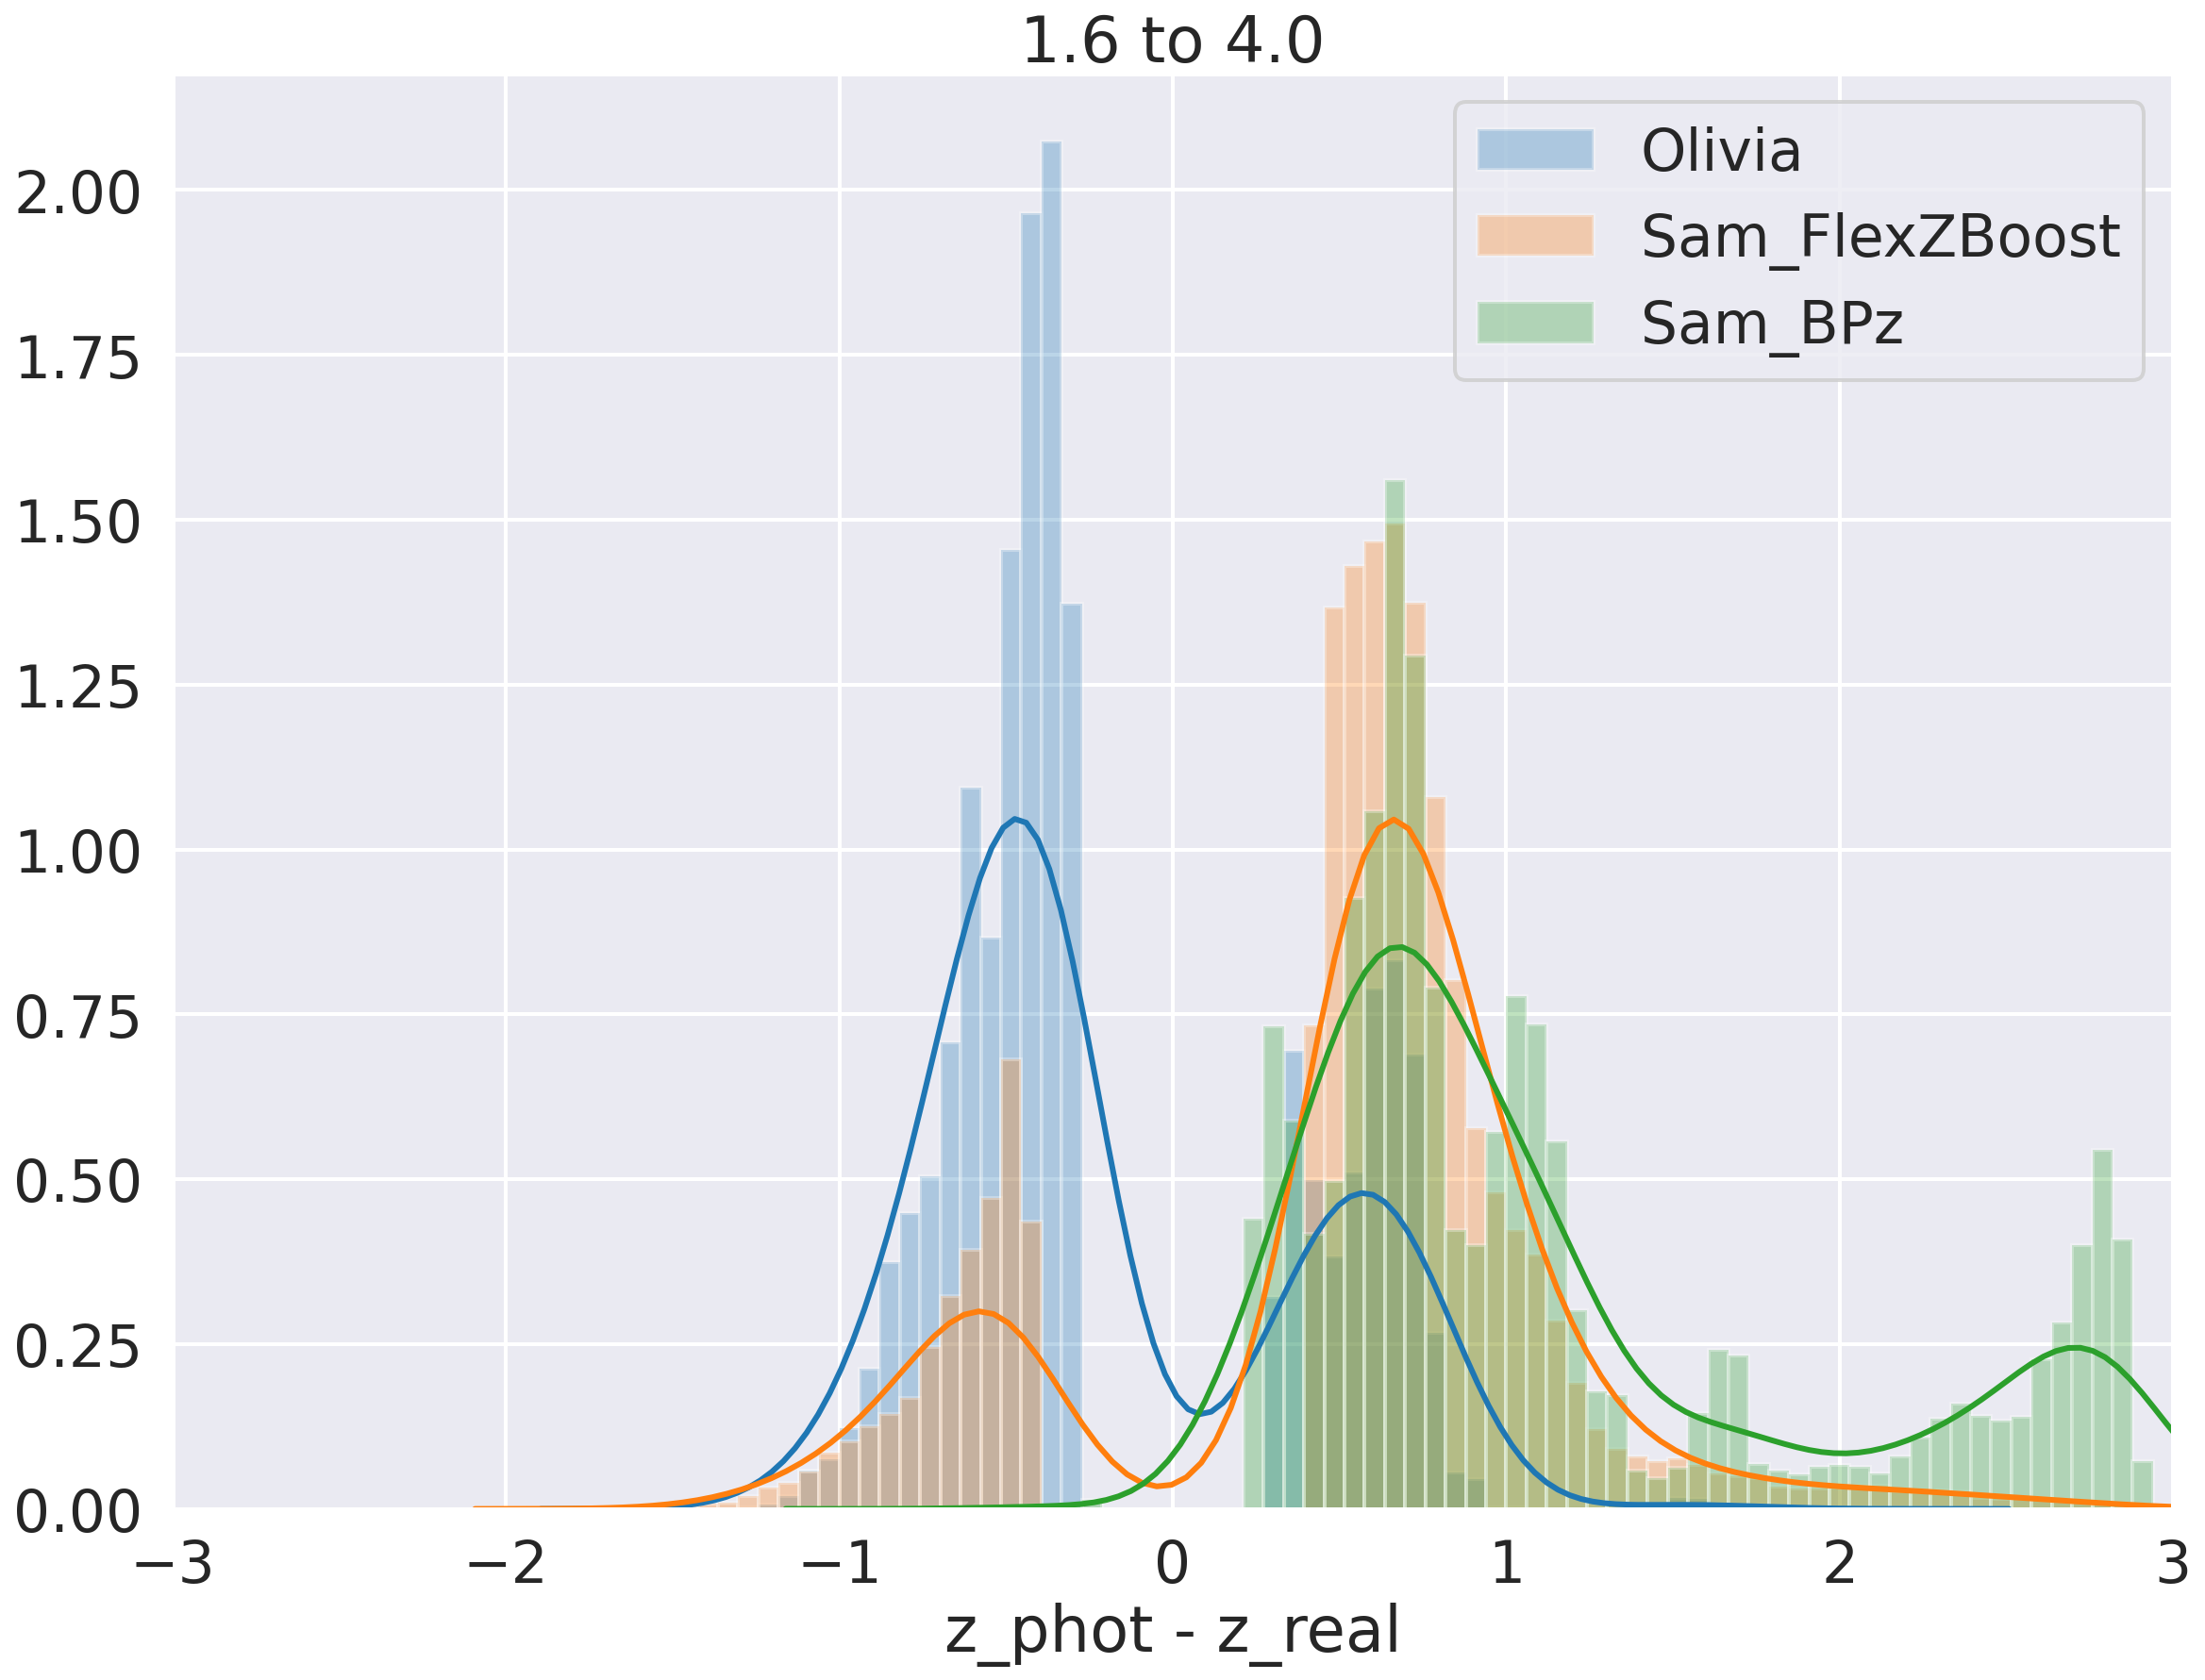

In [71]:
edges = [0.05, 0.55, 0.75, 1.15, 1.55, 3.95]
for i in range(len(edges)-1):
    plt.figure()
    for data in zip([df1, df2, bpz],
                    ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                    ['rz_real', 'redshift', 'redshift_lsst'],
                    ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
        df = data[0]
        errors = df[data[2]] - df[data[3]]
        outliers = np.abs(errors) > 3 * iqr(errors)
        data_in_bin = df[np.logical_and(df[data[3]]>edges[i], df[data[3]]<edges[i+1])] 
        sns.distplot(data_in_bin[outliers][data[3]] - data_in_bin[outliers][data[2]], label=data[1], hist_kws=dict(alpha=0.3), kde_kws=dict(bw=0.2), bins=np.linspace(-3 ,3, 100));
    plt.legend()
    plt.xlim((-3, 3))
    plt.title('{:.1f} to {:.1f}'.format(edges[i], edges[i+1]))
    plt.xlabel('z_phot - z_real')

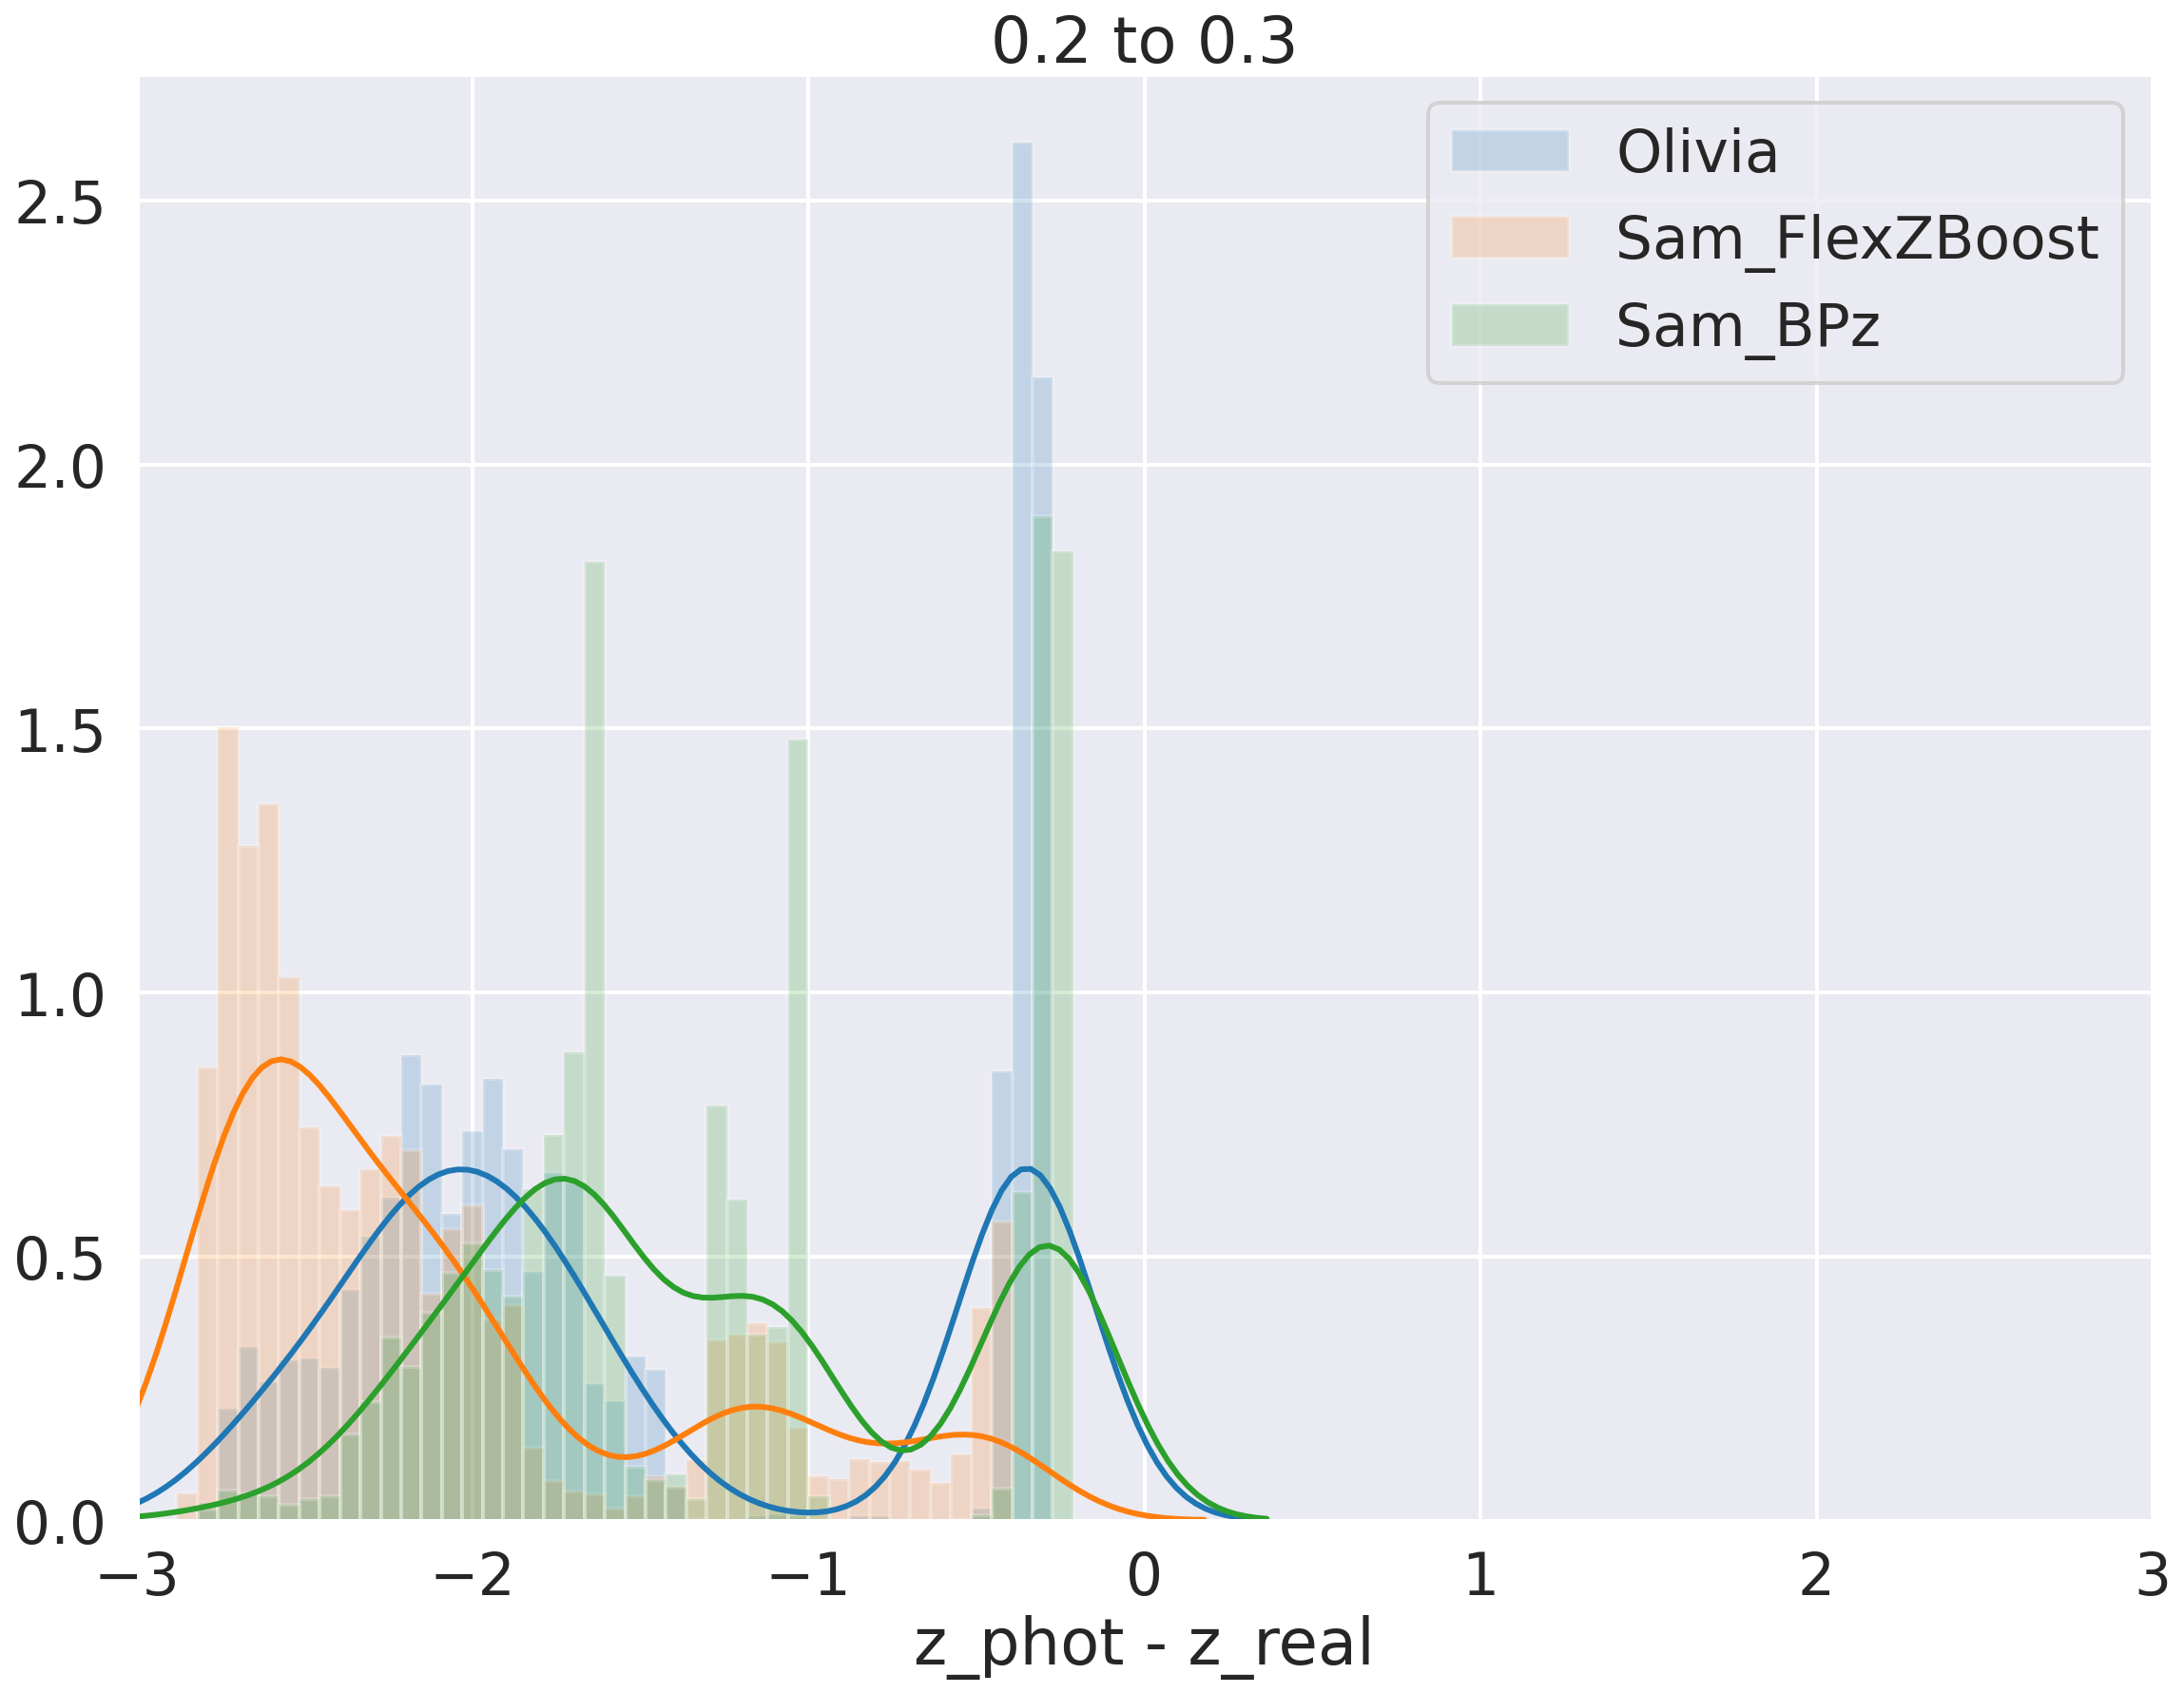

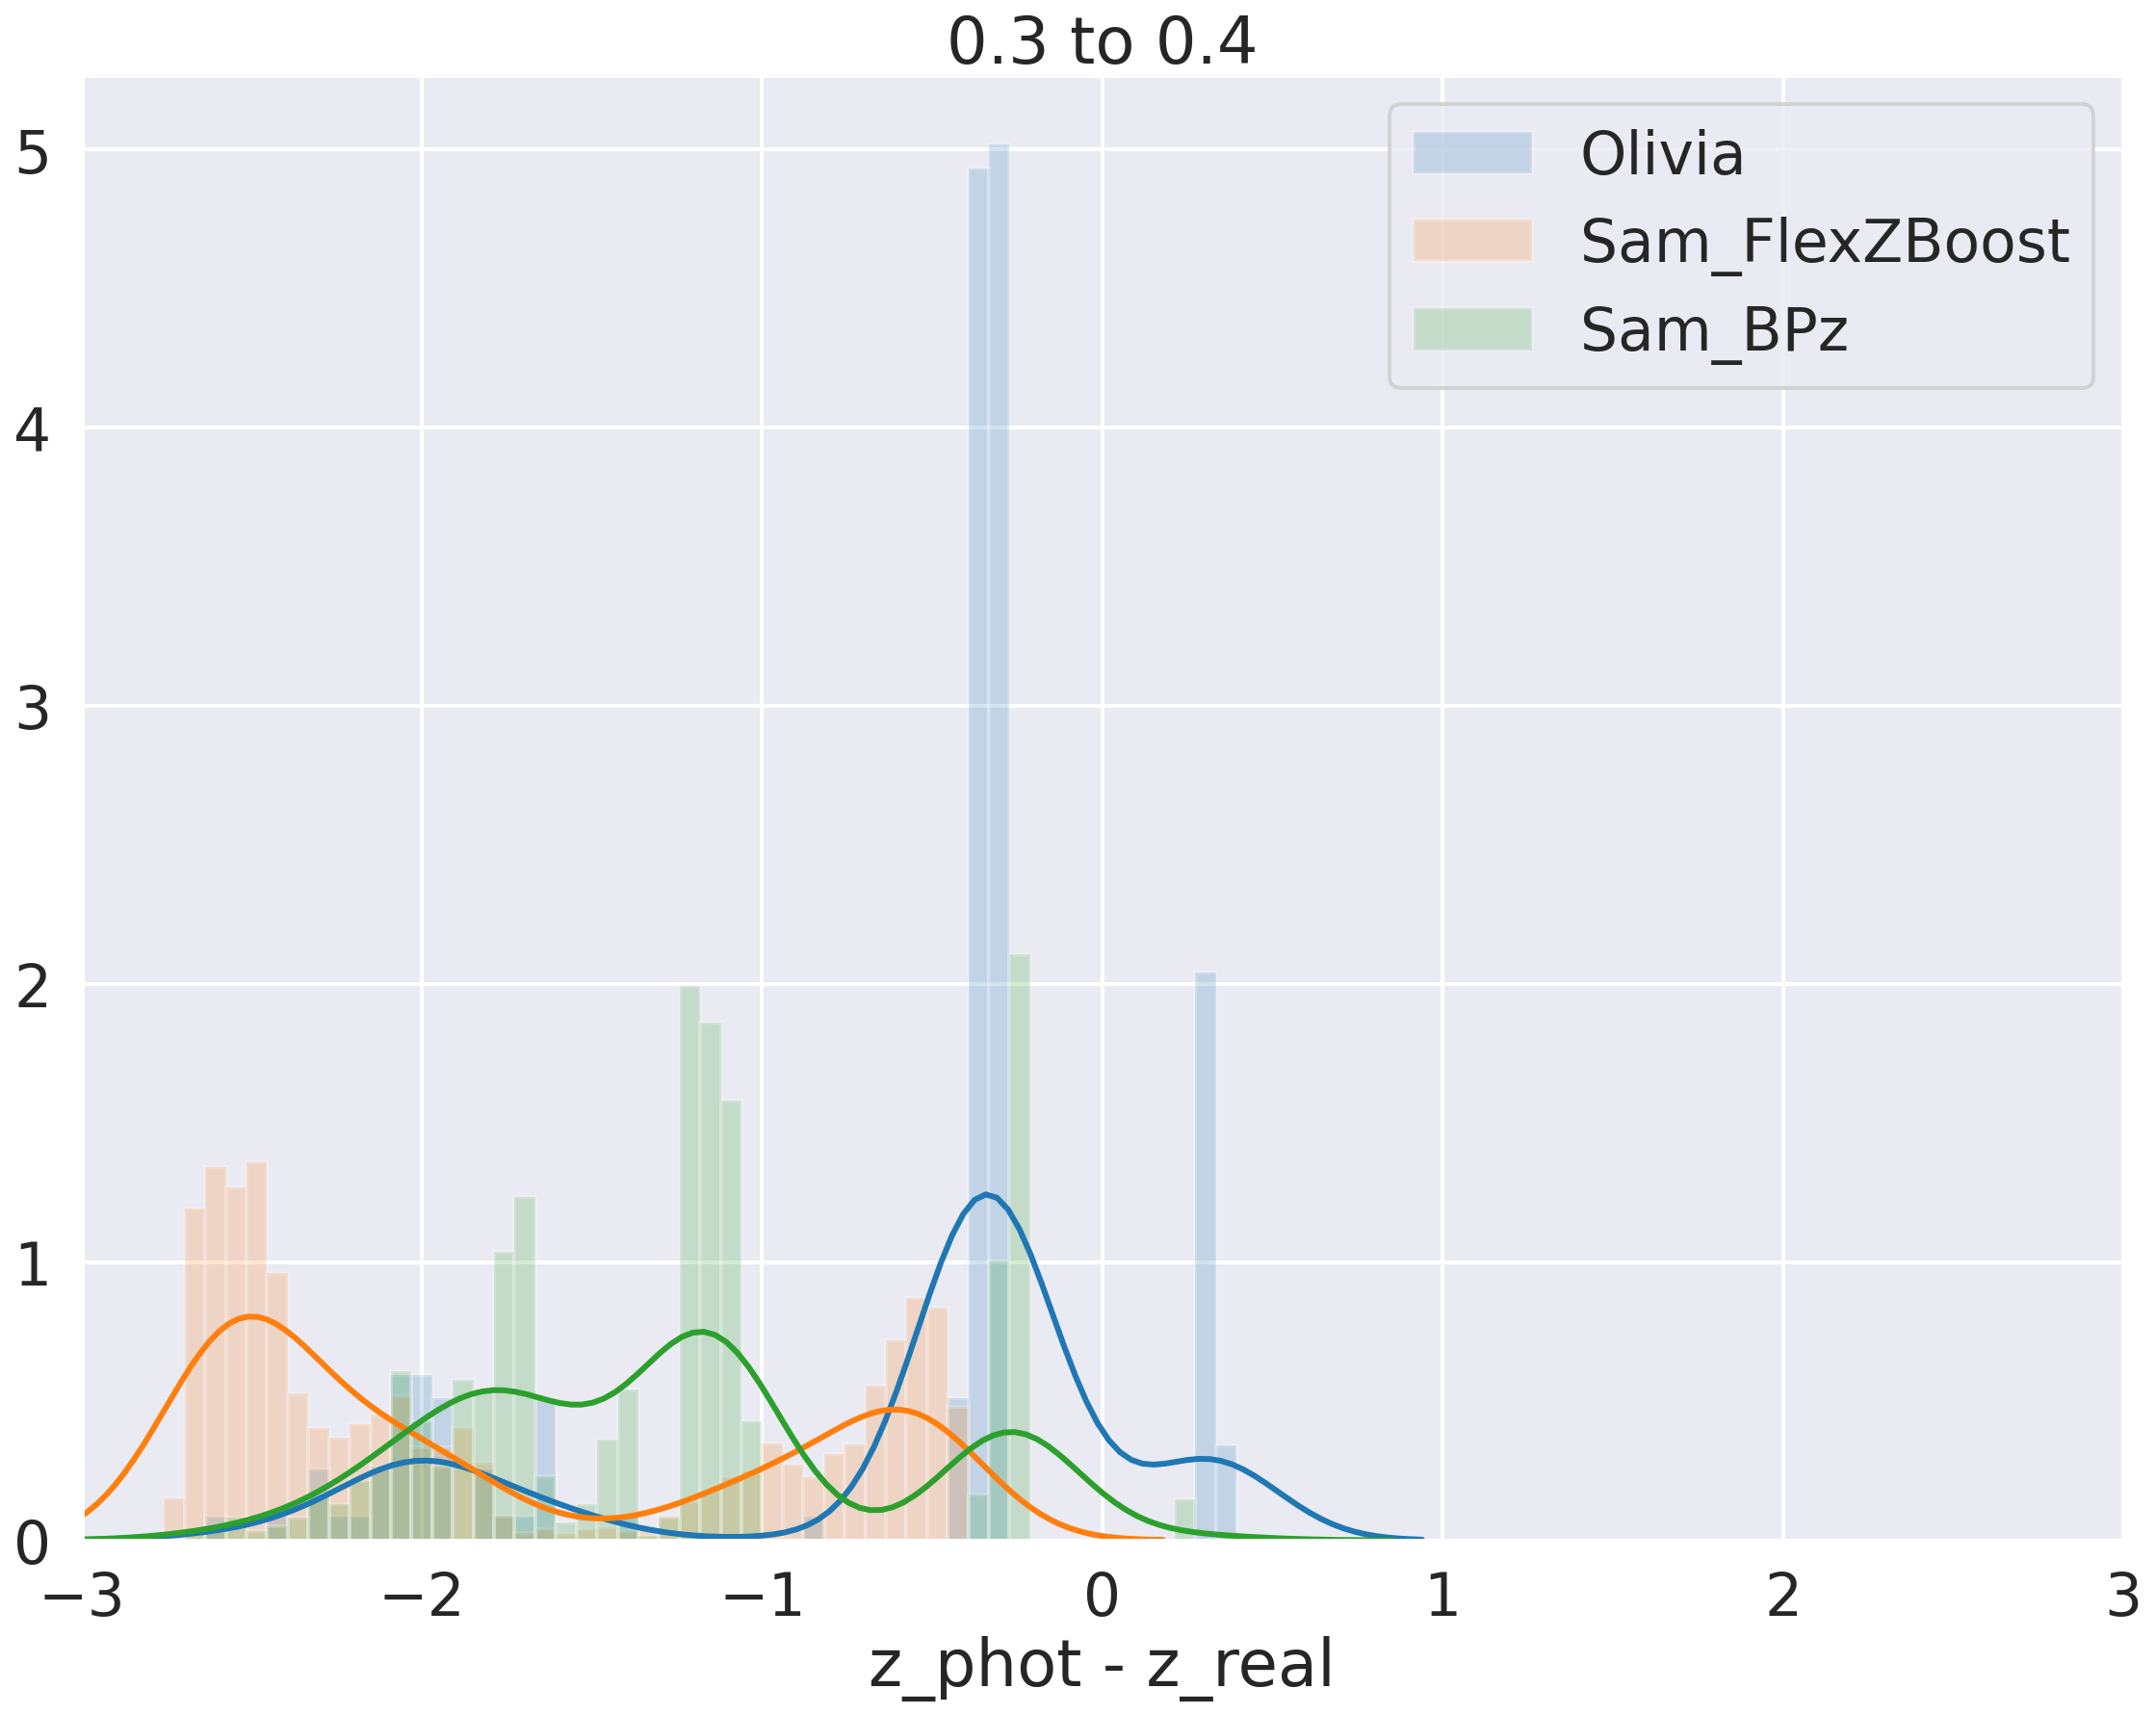

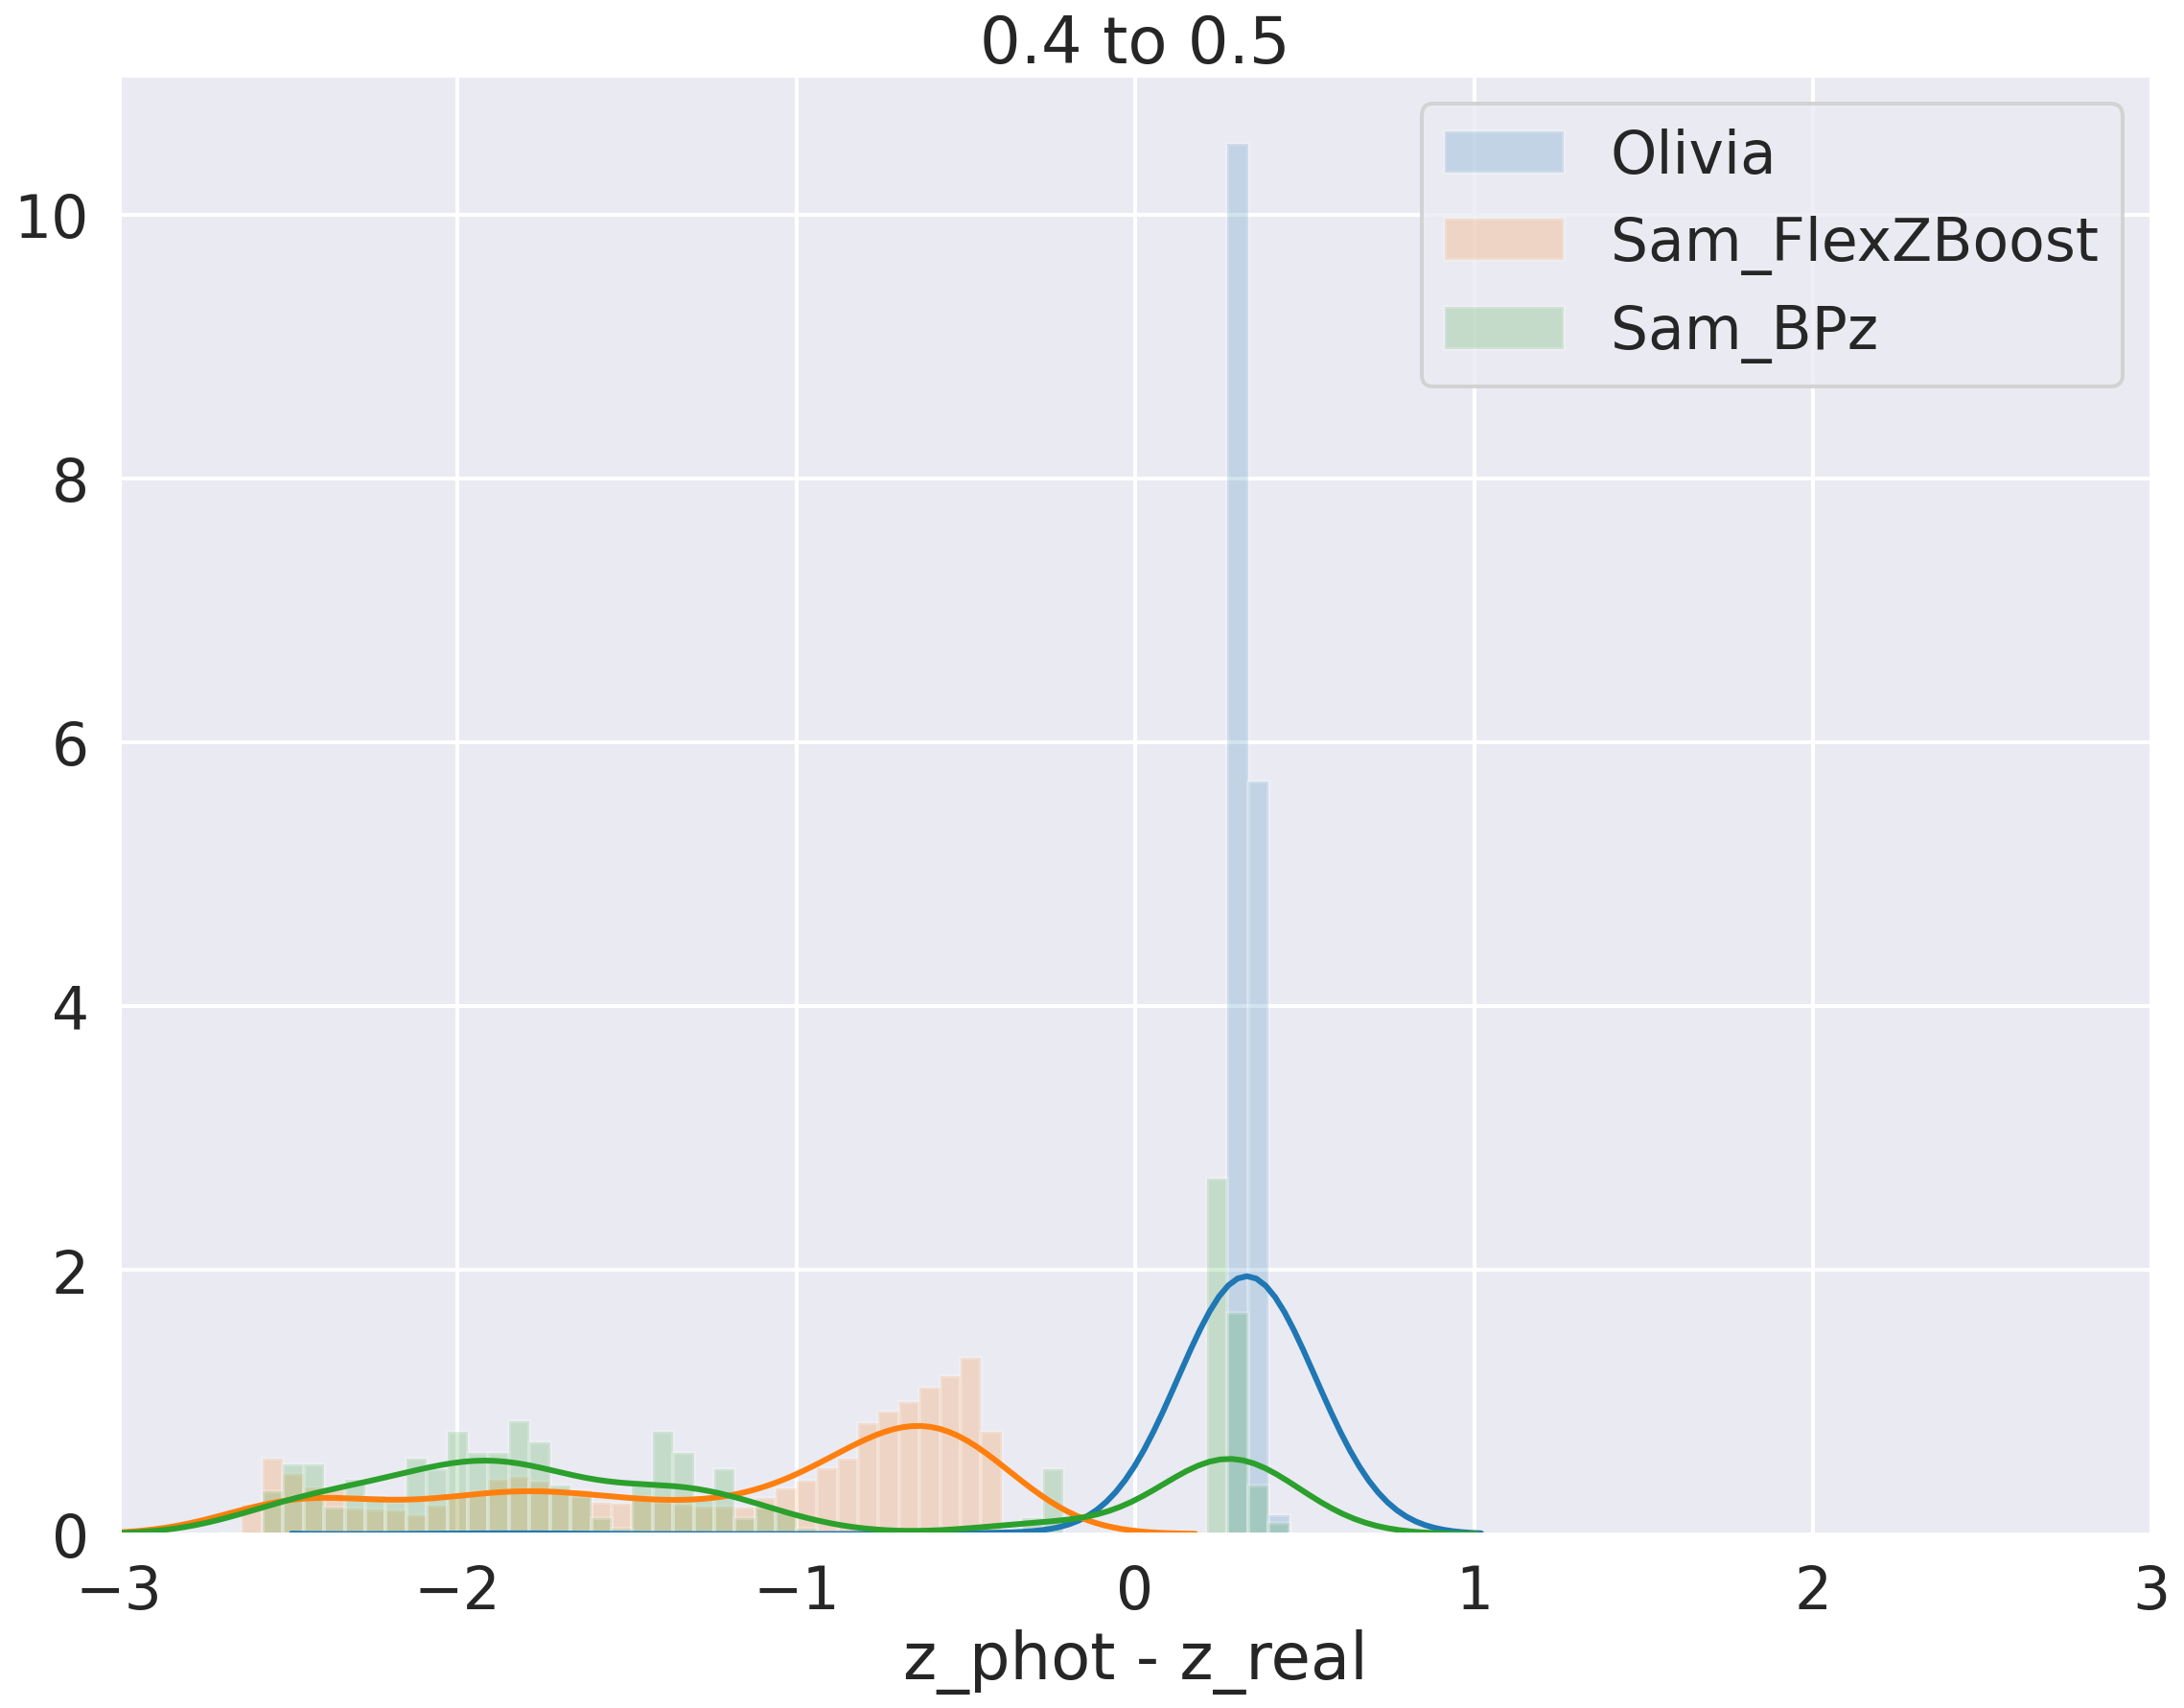

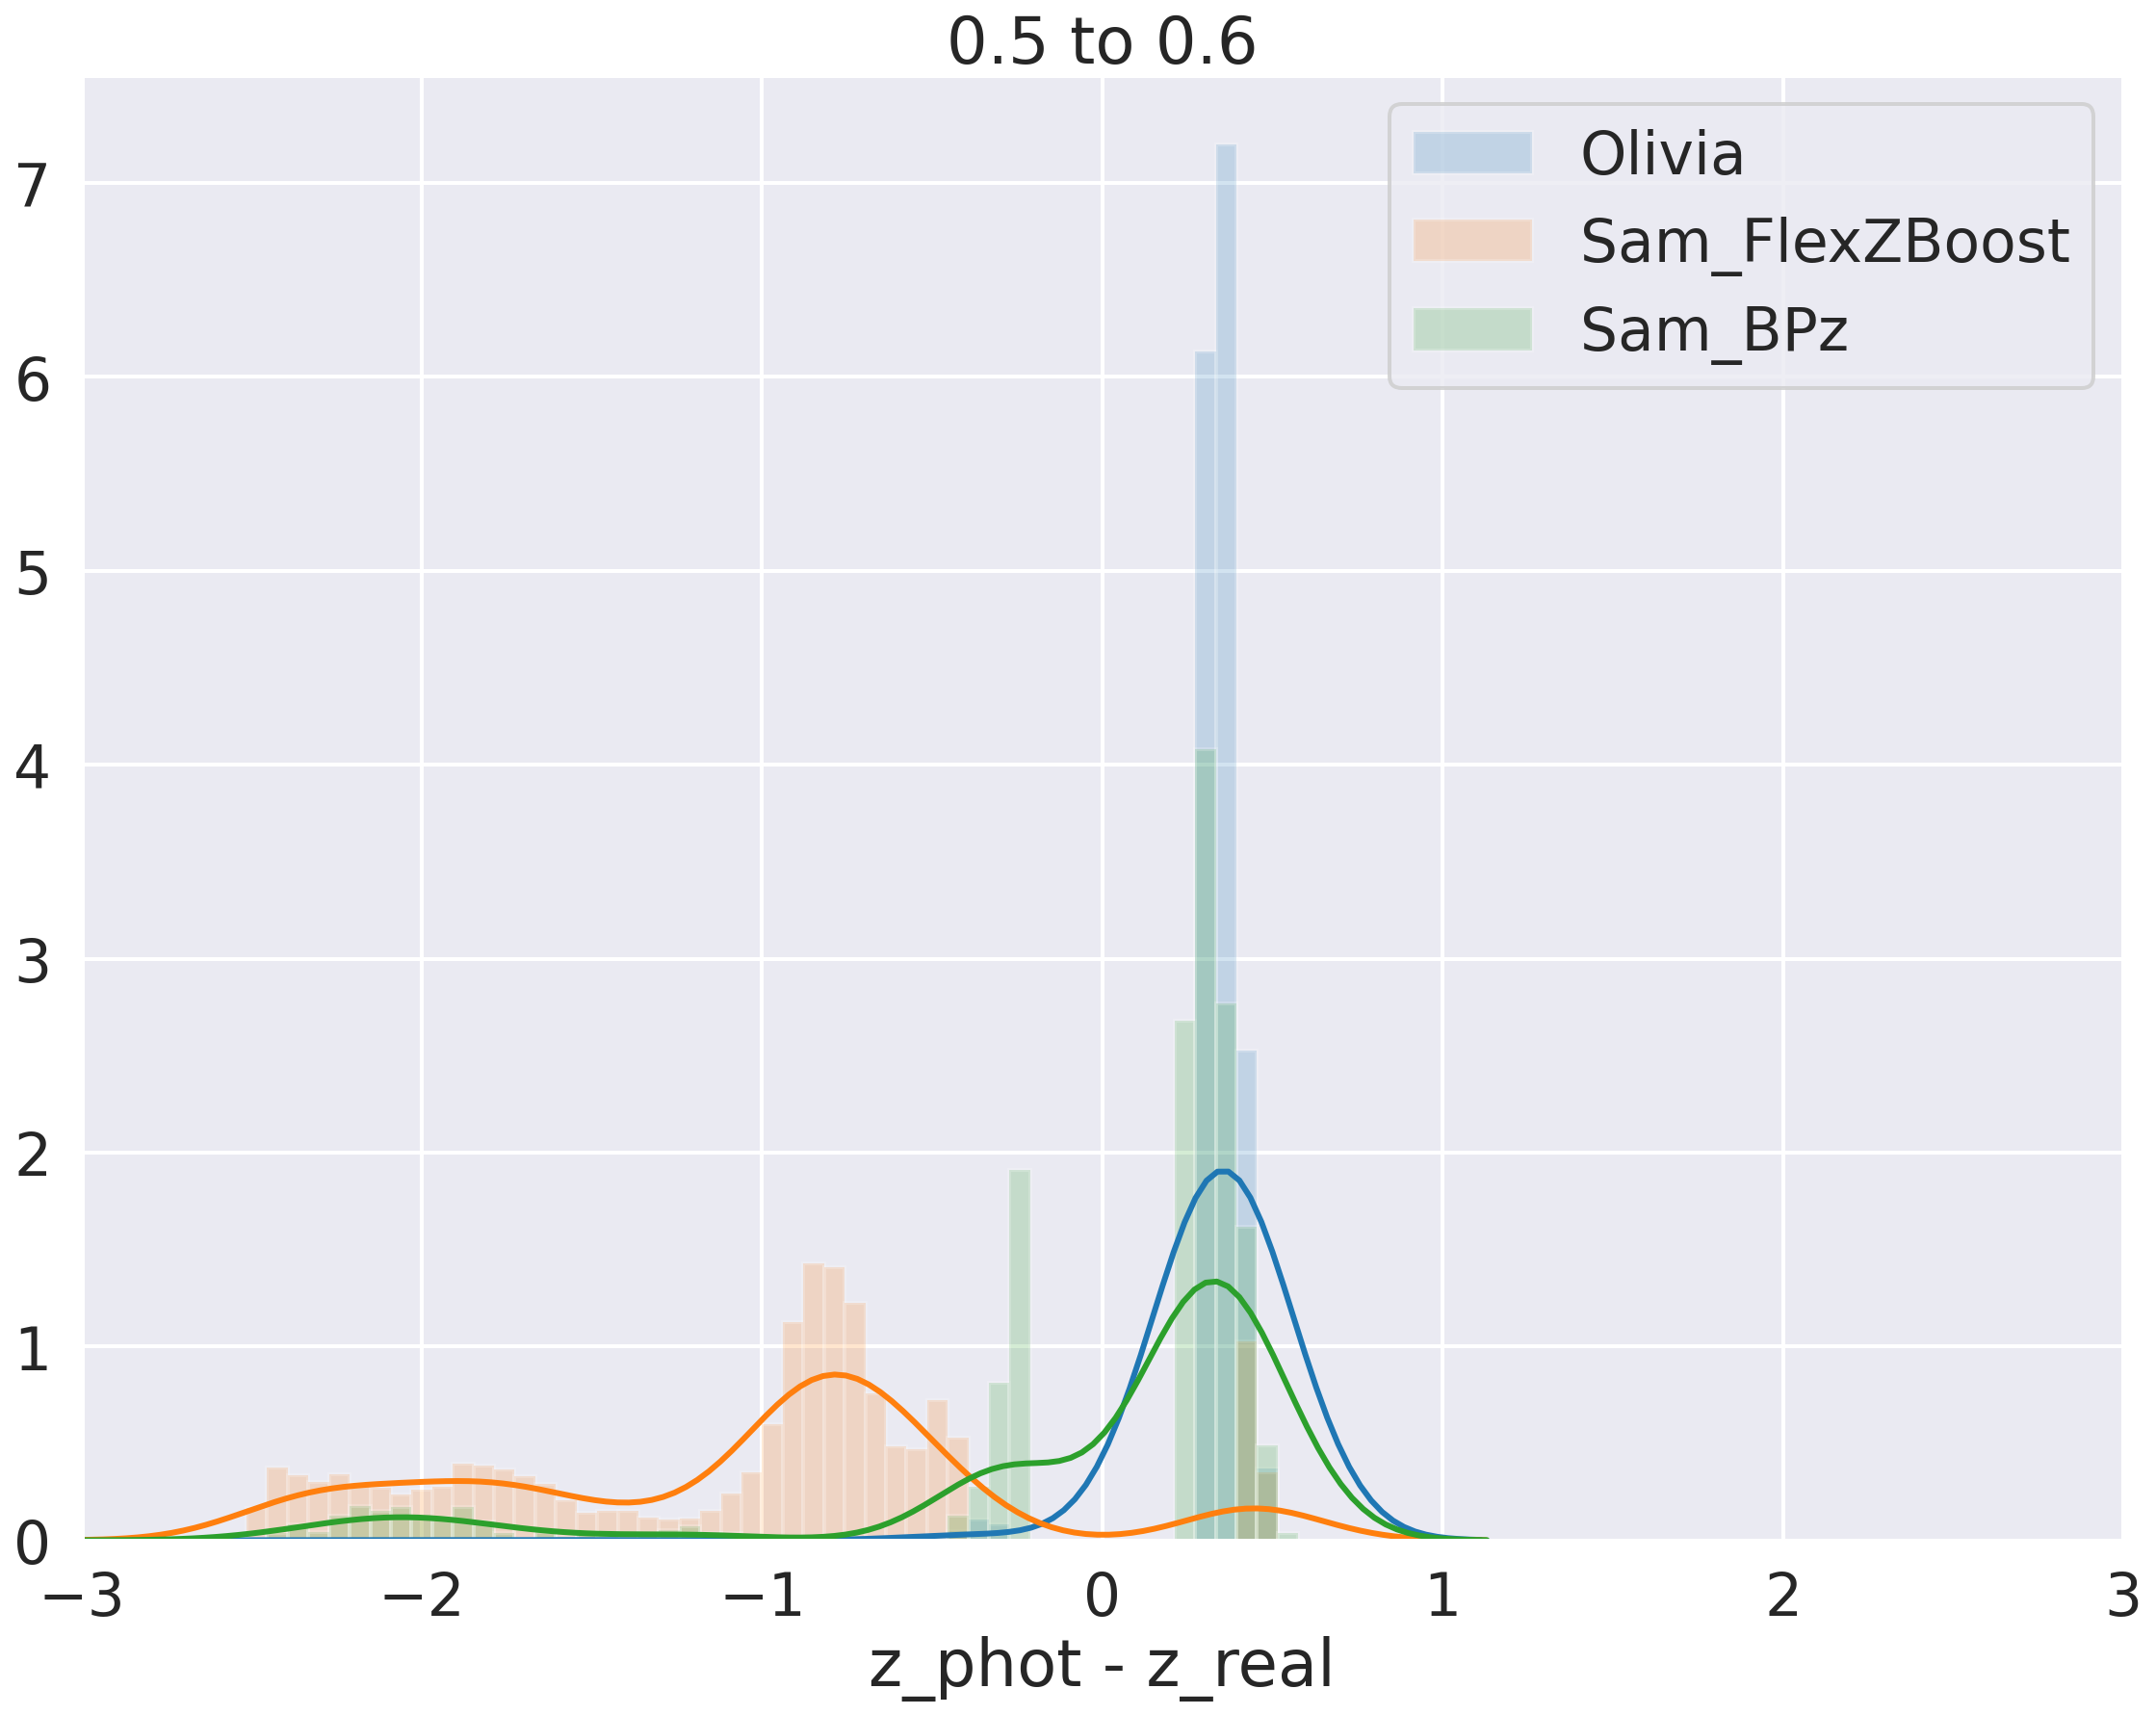

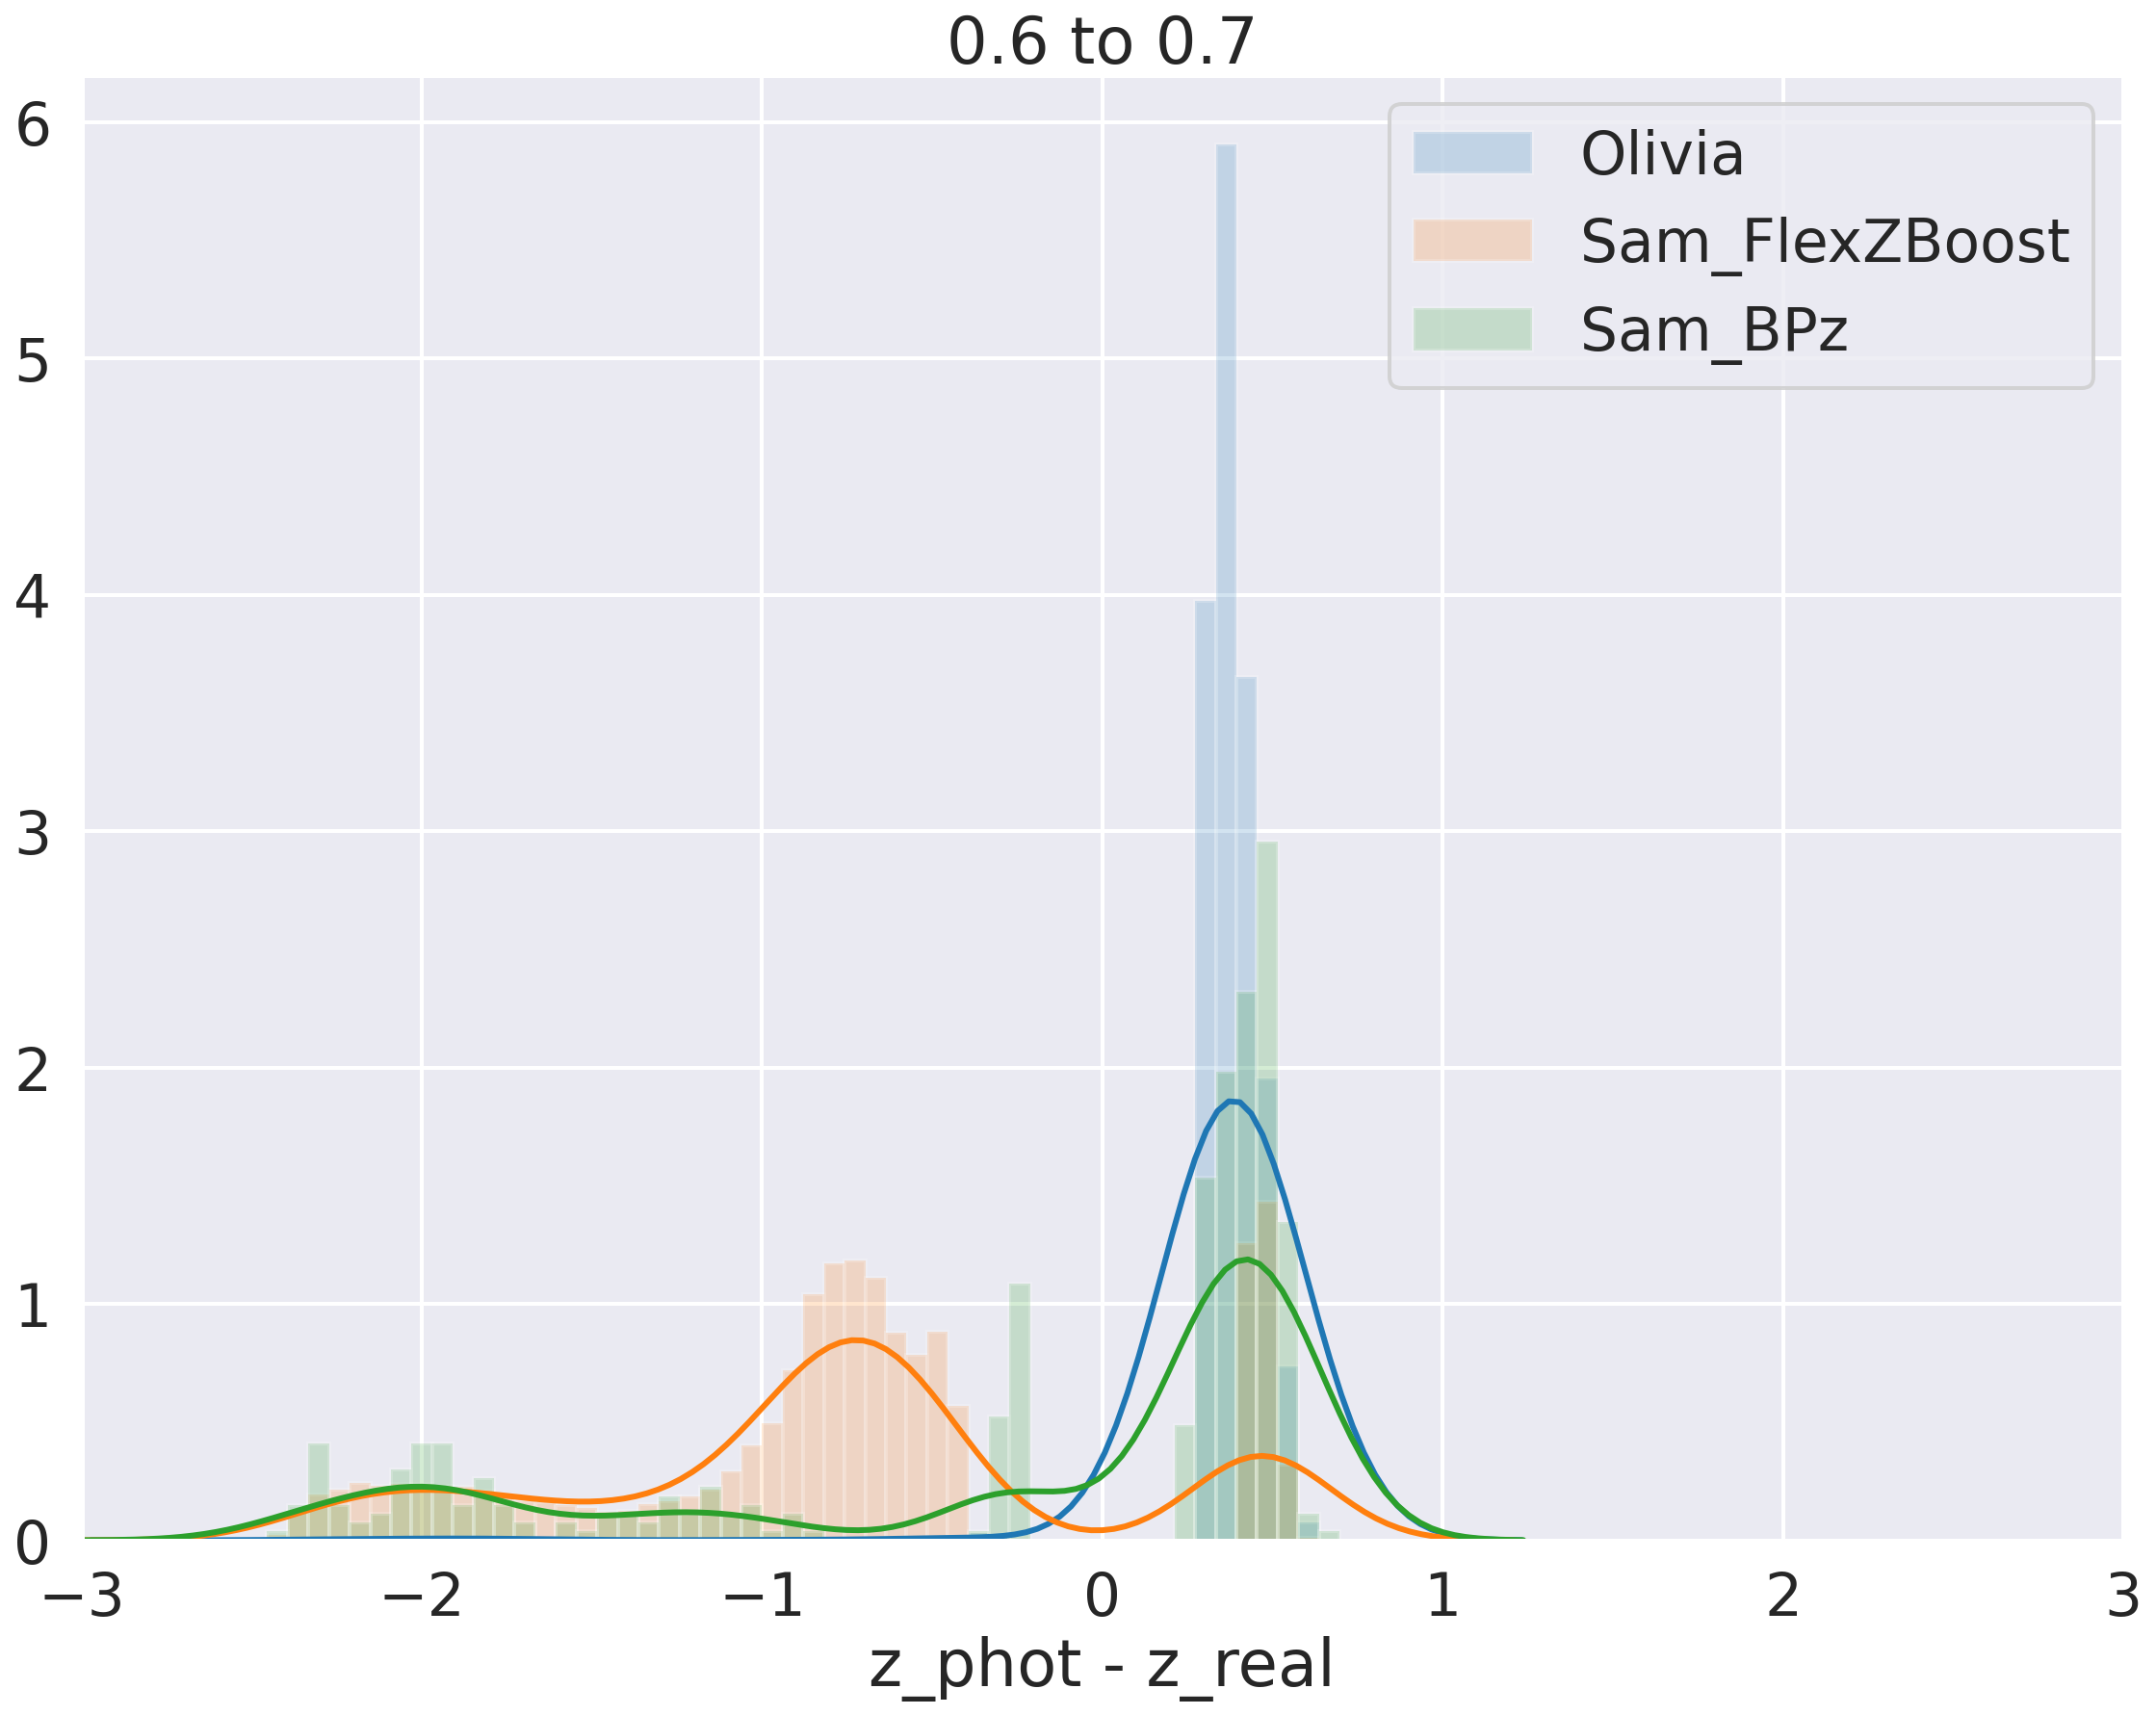

In [ ]:
edges = np.linspace(0.2, 1.2, 11)
for i in range(len(edges)-1):
    plt.figure()
    for data in zip([df1, df2, bpz],
                    ['Olivia', 'Sam_FlexZBoost', 'Sam_BPz'],
                    ['rz_real', 'redshift', 'redshift_lsst'],
                    ['photoz_mode', 'photoz_mode', 'galaxy_points_z_mode']):
        df = data[0]
        errors = df[data[2]] - df[data[3]]
        outliers = np.abs(errors) > 3 * iqr(errors)
        data_in_bin = df[np.logical_and(df[data[3]]>edges[i], df[data[3]]<edges[i+1])] 
        sns.distplot(data_in_bin[outliers][data[3]] - data_in_bin[outliers][data[2]], label=data[1], hist_kws=dict(alpha=0.2), kde_kws=dict(bw=0.2), bins=np.linspace(-3 ,3, 100));
    plt.legend()
    plt.xlim((-3, 3))
    plt.title('{:.1f} to {:.1f}'.format(edges[i], edges[i+1]))
    plt.xlabel('z_phot - z_real')